['depression', 'days']
[(127, 197, 174), (121, 139, 163), (73, 70, 111), (69, 35, 92), (64, 6, 90)]


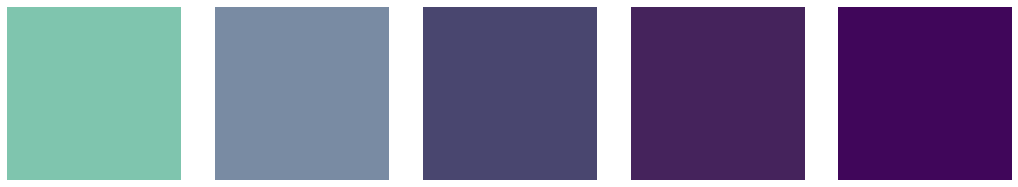

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropy.visualization import make_lupton_rgb

with open('/kaggle/input/data-text2color/data/hexcolor_vf/train_names.pkl', 'rb') as fin:
    src_seqs = pickle.load(fin)
    print(src_seqs[7])
    

with open('/kaggle/input/data-text2color/data/hexcolor_vf/train_palettes_rgb.pkl', 'rb') as fin:
    trg_seqs = pickle.load(fin)
    print(trg_seqs[7])
    
for index, palettes in enumerate(trg_seqs[7:8]):
    image_r, image_g, image_b = [],[],[]
    for palette in palettes:
        image_r.append(palette[0]/255)
        image_g.append(palette[1]/255)
        image_b.append(palette[2]/255)
        
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, sharex=True,figsize=(18, 18))
ax0.imshow(np.array([[[image_r[0], image_g[0], image_b[0]]]]))
ax0.axis('off')
ax1.imshow(np.array([[[image_r[1], image_g[1], image_b[1]]]]))
ax1.axis('off')
ax2.imshow(np.array([[[image_r[2], image_g[2], image_b[2]]]]))
ax2.axis('off')
ax3.imshow(np.array([[[image_r[3], image_g[3], image_b[3]]]]))
ax3.axis('off')
ax4.imshow(np.array([[[image_r[4], image_g[4], image_b[4]]]]))
ax4.axis('off')
plt.show()

# Load data

In [2]:
import torch
import torch.utils.data as data
import pickle
import os
import numpy as np
from skimage.color import rgb2lab
import warnings

class PAT_Dataset(data.Dataset):
    def __init__(self, src_path, trg_path, input_dict):
        with open(src_path, 'rb') as fin:
            self.src_seqs = pickle.load(fin)
        with open(trg_path, 'rb') as fin:
            self.trg_seqs = pickle.load(fin)

        words_index = []
        for index, palette_name in enumerate(self.src_seqs):
            temp = [0] * input_dict.max_len

            for i, word in enumerate(palette_name):
                temp[i] = input_dict.word2index[word]
            words_index.append(temp)
        self.src_seqs = torch.LongTensor(words_index)

        palette_list = []
        for index, palettes in enumerate(self.trg_seqs):
            temp = []
            for palette in palettes:
                rgb = np.array([palette[0], palette[1], palette[2]]) / 255.0
                warnings.filterwarnings("ignore")
                lab = rgb2lab(rgb[np.newaxis, np.newaxis, :], illuminant='D50').flatten()
                temp.append(lab[0])
                temp.append(lab[1])
                temp.append(lab[2])
            palette_list.append(temp)

        self.trg_seqs = torch.FloatTensor(palette_list)
        self.num_total_seqs = len(self.src_seqs)

    def __getitem__(self, index):
        src_seq = self.src_seqs[index]
        trg_seq = self.trg_seqs[index]
        return src_seq, trg_seq

    def __len__(self):
        return self.num_total_seqs


def t2p_loader(batch_size, input_dict):
    train_src_path = os.path.join('/kaggle/input/data-text2color/data/hexcolor_vf/train_names.pkl')
    train_trg_path = os.path.join('/kaggle/input/data-text2color/data/hexcolor_vf/train_palettes_rgb.pkl')
    val_src_path = os.path.join('/kaggle/input/data-text2color/data/hexcolor_vf/test_names.pkl')
    val_trg_path = os.path.join('/kaggle/input/data-text2color/data/hexcolor_vf/test_palettes_rgb.pkl')

    train_dataset = PAT_Dataset(train_src_path, train_trg_path, input_dict)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               num_workers=2,
                                               drop_last=True,
                                               shuffle=True)

    test_dataset = PAT_Dataset(val_src_path, val_trg_path, input_dict)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=batch_size,
                                             num_workers=2,
                                             drop_last=True,
                                             shuffle=False)

    return train_loader, test_loader

class Test_Dataset(data.Dataset):
    def __init__(self, input_dict, txt_path, pal_path, img_path, transform=None):
        self.transform = transform
        with open(img_path, 'rb') as f:
            self.images = np.asarray(pickle.load(f)[:50]) / 255
        with open(txt_path, 'rb') as fin:
            self.src_seqs = pickle.load(fin)[:50]
        with open(pal_path, 'rb') as fin:
            self.trg_seqs = pickle.load(fin)[:50]

        # ==================== Preprocessing src_seqs ====================#
        # Return a list of indexes, one for each word in the sentence.
        words_index = []
        for index, palette_name in enumerate(self.src_seqs):
            # Set list size to the longest palette name.
            temp = [0] * input_dict.max_len
            for i, word in enumerate(palette_name):
                temp[i] = input_dict.word2index[word]
            words_index.append(temp)

        self.src_seqs = torch.LongTensor(words_index)

        # ==================== Preprocessing trg_seqs ====================#
        palette_list = []
        for palettes in self.trg_seqs:
            temp = []
            for palette in palettes:
                rgb = np.array([palette[0], palette[1], palette[2]]) / 255.0
                warnings.filterwarnings("ignore")
                lab = rgb2lab(rgb[np.newaxis, np.newaxis, :], illuminant='D50').flatten()
                temp.append(lab[0])
                temp.append(lab[1])
                temp.append(lab[2])
            palette_list.append(temp)

        self.trg_seqs = torch.FloatTensor(palette_list)

        self.num_total_data = len(self.src_seqs)

    def __len__(self):
        return self.num_total_data

    def __getitem__(self, idx):
        """Returns one data pair."""
        text = self.src_seqs[idx]
        palette = self.trg_seqs[idx]
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)

        return text, palette, image


def test_loader(dataset, batch_size, input_dict):

    if dataset == 'bird256':

        txt_path = '/kaggle/input/data-text2color/data/hexcolor_vf/test_names.pkl'
        pal_path = '/kaggle/input/data-text2color/data/hexcolor_vf/test_palettes_rgb.pkl'
        img_path = '/kaggle/input/data-text2color/data/bird256/test_palette/test_images_origin.txt'

        test_dataset = Test_Dataset(input_dict, txt_path, pal_path, img_path)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)
        imsize = 256

    return test_loader, imsize

# Solver

In [3]:
import torch
import torch.nn as nn
import os
import time
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from skimage.color import lab2rgb

class Solver(object):
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Build the model.
        self.build_model(args.mode)

    def prepare_dict(self):
        input_dict = Dictionary()
        src_path = os.path.join('/kaggle/input/data-text2color/data/hexcolor_vf/all_names.pkl')
        with open(src_path, 'rb') as f:
            text_data = pickle.load(f)
            f.close()

        print("Loading %s palette names..." % len(text_data))
        print("Making text dictionary...")

        for i in range(len(text_data)):
            input_dict.index_elements(text_data[i])
        return input_dict

    def prepare_data(self, images, palettes, always_give_global_hint, add_L):
        batch = images.size(0)
        imsize = images.size(3)

        inputs, labels = process_image(images, batch, imsize)
        if add_L:
            for_global = process_palette_lab(palettes, batch)
            global_hint = process_global_lab(for_global, batch, always_give_global_hint)
        else:
            for_global = process_palette_ab(palettes, batch)
            global_hint = process_global_ab(for_global, batch, always_give_global_hint)

        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        global_hint = (global_hint).expand(-1, -1, imsize, imsize).to(self.device)
        return inputs, labels, global_hint


    def build_model(self, mode):

        if mode == 'train_TPN':
            # Data loader.
            self.input_dict = self.prepare_dict()
            self.train_loader, _ = t2p_loader(self.args.batch_size, self.input_dict)

            # Load pre-trained GloVe embeddings.
            emb_file = os.path.join('/kaggle/input/data-text2color/data', 'Color-Hex-vf.pth')
            if os.path.isfile(emb_file):
                W_emb = torch.load(emb_file)
            else:
                W_emb = load_pretrained_embedding(self.input_dict.word2index,
                                                  '/kaggle/input/glove840b300dtxt/glove.840B.300d.txt',
                                                  300)
                W_emb = torch.from_numpy(W_emb)
                torch.save(W_emb, emb_file)
            W_emb = W_emb.to(self.device)

            # Generator and discriminator.
            self.encoder = EncoderRNN(self.input_dict.n_words, self.args.hidden_size,
                                      self.args.n_layers, self.args.dropout_p, W_emb).to(self.device)
            self.G = AttnDecoderRNN(self.input_dict, self.args.hidden_size,
                                    self.args.n_layers, self.args.dropout_p).to(self.device)
            self.D = Discriminator(15, self.args.hidden_size).to(self.device)

            # Initialize weights.
            self.encoder.apply(init_weights_normal)
            self.G.apply(init_weights_normal)
            self.D.apply(init_weights_normal)

            # Optimizer.
            self.G_parameters = list(self.encoder.parameters()) + list(self.G.parameters())
            self.g_optimizer = torch.optim.Adam(self.G_parameters,
                                                lr=self.args.lr, weight_decay=self.args.weight_decay)
            self.d_optimizer = torch.optim.Adam(self.D.parameters(),
                                                lr=self.args.lr, betas=(self.args.beta1, self.args.beta2))

        elif mode == 'test_TPN' or 'test_text2colors' or 'sample_TPN':
            
            # Data loader.
            self.input_dict = self.prepare_dict()

            # Load pre-trained GloVe embeddings.
            emb_file = os.path.join('/kaggle/input/data-text2color/data', 'Color-Hex-vf.pth')
            if os.path.isfile(emb_file):
                W_emb = torch.load(emb_file)
            else:
                W_emb = load_pretrained_embedding(self.input_dict.word2index,
                                                  '/kaggle/input/glove840b300dtxt/glove.840B.300d.txt',
                                                  300)
                W_emb = torch.from_numpy(W_emb)
                torch.save(W_emb, emb_file)
            W_emb = W_emb.to(self.device)

            # Data loader.
            self.test_loader, self.imsize = test_loader(self.args.dataset, self.args.batch_size, self.input_dict)

            # Load the trained generators.
            self.encoder = EncoderRNN(self.input_dict.n_words, self.args.hidden_size,
                                          self.args.n_layers, self.args.dropout_p, W_emb).to(self.device)
            self.G_TPN = AttnDecoderRNN(self.input_dict, self.args.hidden_size,
                                        self.args.n_layers, self.args.dropout_p).to(self.device)
            # Load model.
            if self.args.resume_epoch:
                self.load_model(self.args.mode, self.args.resume_epoch)

    def load_model(self, mode, resume_epoch):
        print('Loading the trained model from epoch {}...'.format(resume_epoch))
        if mode == 'train_TPN':
            encoder_path = os.path.join(self.args.text2pal_dir, '{}_G_encoder.ckpt'.format(resume_epoch))
            G_path = os.path.join(self.args.text2pal_dir, '{}_G_decoder.ckpt'.format(resume_epoch))
            D_path = os.path.join(self.args.text2pal_dir, '{}_D.ckpt'.format(resume_epoch))
            self.encoder.load_state_dict(torch.load(encoder_path, map_location=lambda storage, loc: storage))
            self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
            self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
            
        elif mode == 'test_TPN' or 'sample_TPN':
            encoder_path = os.path.join(self.args.text2pal_dir, '{}_G_encoder.ckpt'.format(resume_epoch))
            G_TPN_path = os.path.join(self.args.text2pal_dir, '{}_G_decoder.ckpt'.format(resume_epoch))
            self.encoder.load_state_dict(torch.load(encoder_path, map_location=lambda storage, loc: storage))
            self.G_TPN.load_state_dict(torch.load(G_TPN_path, map_location=lambda storage, loc: storage))

        elif mode == 'test_text2colors':
            encoder_path = os.path.join(self.args.text2pal_dir, '{}_G_encoder.ckpt'.format(resume_epoch))
            G_TPN_path = os.path.join(self.args.text2pal_dir, '{}_G_decoder.ckpt'.format(resume_epoch))
            G_PCN_path = os.path.join(self.args.pal2color_dir, '{}_G.ckpt'.format(resume_epoch))
            self.encoder.load_state_dict(torch.load(encoder_path, map_location=lambda storage, loc: storage))
            self.G_TPN.load_state_dict(torch.load(G_TPN_path, map_location=lambda storage, loc: storage))
            self.G_PCN.load_state_dict(torch.load(G_PCN_path, map_location=lambda storage, loc: storage))


    def train_TPN(self):
        losses = []
        # Loss function.
        criterion_GAN = nn.BCELoss()
        criterion_smoothL1 = nn.SmoothL1Loss()

        # Start training from scratch or resume training.
        start_epoch = 0
        if self.args.resume_epoch:
            start_epoch = self.args.resume_epoch
            self.load_model(self.args.mode, self.args.resume_epoch)

        self.encoder.train()
        self.G.train()
        self.D.train()

        print('Start training...')
        start_time = time.time()
        for epoch in range(start_epoch, self.args.num_epochs):
            for batch_idx, (txt_embeddings, real_palettes) in enumerate(self.train_loader):

                # Compute text input size (without zero padding).
                batch_size = txt_embeddings.size(0)
                nonzero_indices = list(torch.nonzero(txt_embeddings)[:, 0])
                each_input_size = [nonzero_indices.count(j) for j in range(batch_size)]

                # Prepare training data.
                txt_embeddings = txt_embeddings.to(self.device)
                real_palettes = real_palettes.to(self.device).float()

                # Prepare labels for the BCE loss.
                real_labels = torch.ones(batch_size).to(self.device)
                fake_labels = torch.zeros(batch_size).to(self.device)

                # Prepare input and output variables.
                palette = torch.FloatTensor(batch_size, 3).zero_().to(self.device)
                fake_palettes = torch.FloatTensor(batch_size, 15).zero_().to(self.device)

                # Condition for the generator.
                encoder_hidden = self.encoder.init_hidden(batch_size).to(self.device)
                encoder_outputs, decoder_hidden, mu, logvar = self.encoder(txt_embeddings, encoder_hidden)

                # Generate color palette.
                for i in range(5):
                    palette, decoder_context, decoder_hidden, _ = self.G(palette,
                                                                         decoder_hidden.squeeze(0),
                                                                         encoder_outputs,
                                                                         each_input_size,
                                                                         i)
                    fake_palettes[:, 3 * i:3 * (i+1)] = palette

                # Condition for the discriminator.
                each_input_size = torch.FloatTensor(each_input_size).to(self.device)
                each_input_size = each_input_size.unsqueeze(1).expand(batch_size, self.G.hidden_size)
                encoder_outputs = torch.sum(encoder_outputs, 0)
                encoder_outputs = torch.div(encoder_outputs, each_input_size)

                # =============================== Train the discriminator =============================== #
                # Compute BCE loss using real palettes.
                real = self.D(real_palettes, encoder_outputs)
                d_loss_real = criterion_GAN(real, real_labels)

                # Compute BCE loss using fake palettes.
                fake = self.D(fake_palettes, encoder_outputs)
                d_loss_fake = criterion_GAN(fake, fake_labels)

                d_loss = d_loss_real + d_loss_fake

                # Backprop and optimize.
                self.d_optimizer.zero_grad()
                d_loss.backward(retain_graph=True)
                self.d_optimizer.step()

                # ================================ Train the generator ================================= #
                # Compute BCE loss (fool the discriminator).
                fake = self.D(fake_palettes, encoder_outputs)
                g_loss_GAN = criterion_GAN(fake, real_labels)

                # Compute smooth L1 loss.
                g_loss_smoothL1 = criterion_smoothL1(fake_palettes, real_palettes)

                # Compute KL loss.
                kl_loss = KL_loss(mu, logvar)

                g_loss = g_loss_GAN + g_loss_smoothL1 * self.args.lambda_sL1 + kl_loss * self.args.lambda_KL

                # Backprop and optimize.
                self.g_optimizer.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()

            # For debugging. Save training output.
            if (epoch+1) % self.args.sample_interval == 0:
                for x in range(5):  # saving 5 samples
                    fig1, axs1 = plt.subplots(nrows=1, ncols=5)
                    input_text = ''
                    for idx in txt_embeddings[x]:
                        if idx.item() == 0: break
                        input_text += self.input_dict.index2word[idx.item()] + " "
                    axs1[0].set_title(input_text)
                    for k in range(5):
                        lab = np.array([fake_palettes.data[x][3*k].cpu().numpy(),
                                        fake_palettes.data[x][3*k+1].cpu().numpy(),
                                        fake_palettes.data[x][3*k+2].cpu().numpy()], dtype='float64')
                        rgb = lab2rgb_1d(lab)
                        axs1[k].imshow([[rgb]])
                        axs1[k].axis('off')

                    fig1.savefig(os.path.join(self.args.train_sample_dir,
                                              'epoch{}_sample{}.jpg'.format(epoch+1, x+1)))
                    plt.close()
                print('Saved train sample...')
        
            if (epoch+1) % self.args.log_interval == 0:
                elapsed_time = time.time() - start_time
                print('Elapsed time [{:.4f}], Iteration [{}/{}], '
                      'd_loss: {:.6f}, g_loss: {:.6f}'.format(
                       elapsed_time, (epoch+1), self.args.num_epochs,
                       d_loss.item(), g_loss.item()))
                losses.append((d_loss.item(), g_loss.item()))

            if (epoch+1) % self.args.save_interval == 0:
                torch.save(self.encoder.state_dict(),
                           os.path.join(self.args.text2pal_dir, '{}_G_encoder.ckpt'.format(epoch+1)))
                torch.save(self.G.state_dict(),
                           os.path.join(self.args.text2pal_dir, '{}_G_decoder.ckpt'.format(epoch+1)))
                torch.save(self.D.state_dict(),
                           os.path.join(self.args.text2pal_dir, '{}_D.ckpt'.format(epoch+1)))
                print('Saved model checkpoints...')
                
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
        plt.plot(losses.T[1], label='Generator', alpha=0.5)
        plt.title("Training Losses")
        plt.legend()



    def test_TPN(self):

        print('Start testing...')
        for batch_idx, (txt_embeddings, real_palettes, _) in enumerate(self.test_loader):
            if txt_embeddings.size(0) != self.args.batch_size:
                break

            # Compute text input size (without zero padding).
            batch_size = txt_embeddings.size(0)
            nonzero_indices = list(torch.nonzero(txt_embeddings)[:, 0])
            each_input_size = [nonzero_indices.count(j) for j in range(batch_size)]

            # Prepare test data.
            txt_embeddings = txt_embeddings.to(self.device)
            real_palettes = real_palettes.to(self.device).float()

            # Generate multiple palettes from same text input.
            for num_gen in range(10):

                # Prepare input and output variables.
                palette = torch.FloatTensor(batch_size, 3).zero_().to(self.device)
                fake_palettes = torch.FloatTensor(batch_size, 15).zero_().to(self.device)

                # ============================== Text-to-Palette ==============================#
                # Condition for the generator.
                encoder_hidden = self.encoder.init_hidden(batch_size).to(self.device)
                encoder_outputs, decoder_hidden, mu, logvar = self.encoder(txt_embeddings, encoder_hidden)

                # Generate color palette.
                for i in range(5):
                    palette, decoder_context, decoder_hidden, _ = self.G_TPN(palette,
                                                                             decoder_hidden.squeeze(0),
                                                                             encoder_outputs,
                                                                             each_input_size,
                                                                             i)
                    fake_palettes[:, 3 * i:3 * (i + 1)] = palette

                # ================================ Save Results ================================#
                for x in range(self.args.batch_size):
                    # Input text.
                    input_text = ''
                    for idx in txt_embeddings[x]:
                        if idx.item() == 0: break
                        input_text += self.input_dict.index2word[idx.item()] + ' '

                    # Save palette generation results.
                    fig1, axs1 = plt.subplots(nrows=2, ncols=5)
                    axs1[0][0].set_title(input_text + 'fake {}'.format(num_gen + 1))
                    for k in range(5):
                        lab = np.array([fake_palettes.data[x][3 * k].cpu().numpy(),
                                        fake_palettes.data[x][3 * k + 1].cpu().numpy(),
                                        fake_palettes.data[x][3 * k + 2].cpu().numpy()], dtype='float64')
                        rgb = lab2rgb_1d(lab)
                        axs1[0][k].imshow([[rgb]])
                        axs1[0][k].axis('off')
                    axs1[1][0].set_title(input_text + 'real')
                    for k in range(5):
                        lab = np.array([real_palettes.data[x][3 * k].cpu().numpy(),
                                        real_palettes.data[x][3 * k + 1].cpu().numpy(),
                                        real_palettes.data[x][3 * k + 2].cpu().numpy()], dtype='float64')
                        rgb = lab2rgb_1d(lab)
                        axs1[1][k].imshow([[rgb]])
                        axs1[1][k].axis('off')

                    fig1.savefig(os.path.join(self.args.test_sample_dir, self.args.mode,
                                              '{}_palette{}.jpg'.format(self.args.batch_size*batch_idx+x+1,
                                                                        num_gen+1)))
                    print('Saved data [{}], input text [{}], test sample [{}]'.format(
                          self.args.batch_size*batch_idx+x+1, input_text, num_gen+1))


    def test_text2colors(self):

        print('Start testing...')
        for batch_idx, (txt_embeddings, real_palettes, images) in enumerate(self.test_loader):
            if txt_embeddings.size(0) != self.args.batch_size:
                break

            # Compute text input size (without zero padding).
            batch_size = txt_embeddings.size(0)
            nonzero_indices = list(torch.nonzero(txt_embeddings)[:, 0])
            each_input_size = [nonzero_indices.count(j) for j in range(batch_size)]

            # Prepare test data.
            txt_embeddings = txt_embeddings.to(self.device)
            real_palettes = real_palettes.to(self.device).float()

            for num_gen in range(5):
                # Prepare input and output variables.
                palette = torch.FloatTensor(batch_size, 3).zero_().to(self.device)
                fake_palettes = torch.FloatTensor(batch_size, 15).zero_().to(self.device)
                # ============================== Text-to-Palette ==============================#
                # Condition for the generator.
                encoder_hidden = self.encoder.init_hidden(batch_size).to(self.device)
                encoder_outputs, decoder_hidden, mu, logvar = self.encoder(txt_embeddings, encoder_hidden)

                # Generate color palette.
                for i in range(5):
                    palette, decoder_context, decoder_hidden, _ = self.G_TPN(palette,
                                                                             decoder_hidden.squeeze(0),
                                                                             encoder_outputs,
                                                                             each_input_size,
                                                                             i)
                    fake_palettes[:, 3 * i:3 * (i+1)] = palette

                # ========================= Palette-to-Colorization ============================#
                # Prepare testing data.
                inputs, labels = process_image(images, batch_size, imsize)
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                fake_palettes_ = fake_palettes.view(-1, 5, 3).cpu().data.numpy()
                for_global = process_palette_lab(fake_palettes_, batch_size)
                side_inputs = process_global_sampling_lab(for_global, batch_size, self.imsize, 0.03, 0.13)

                fake_images = self.G_PCN(inputs, side_inputs)
                # ================================ Save Results ================================#
                colored_img = torch.cat([inputs, fake_images], 1).data.cpu().numpy().transpose((0, 2, 3, 1))
                gt_img = images.cpu().numpy().transpose((0, 2, 3, 1))

                for x in range(batch_size):
                    # Input text.
                    input_text = ''
                    for idx in txt_embeddings[x]:
                        if idx.item() == 0: break
                        input_text += self.input_dict.index2word[idx.item()] + " "

                    ## Save palette generation results.
                    fig1, axs1 = plt.subplots(nrows=2, ncols=5)
                    axs1[0][0].set_title(input_text + 'fake {}'.format(num_gen+1))
                    for k in range(5):
                        lab = np.array([fake_palettes.data[x][3*k].cpu().numpy(),
                                        fake_palettes.data[x][3*k+1].cpu().numpy(),
                                        fake_palettes.data[x][3*k+2].cpu().numpy()], dtype='float64')
                        rgb = lab2rgb_1d(lab)
                        axs1[0][k].imshow([[rgb]])
                        axs1[0][k].axis('off')
                    axs1[1][0].set_title(input_text + 'real')
                    for k in range(5):
                        lab = np.array([real_palettes.data[x][3*k].cpu().numpy(),
                                        real_palettes.data[x][3*k+1].cpu().numpy(),
                                        real_palettes.data[x][3*k+2].cpu().numpy()], dtype='float64')
                        rgb = lab2rgb_1d(lab)
                        axs1[1][k].imshow([[rgb]])
                        axs1[1][k].axis('off')

                    fig1.savefig(os.path.join(self.args.test_sample_dir, self.args.mode,
                                              '{}_palette{}.jpg'.format(self.args.batch_size*batch_idx+x+1,num_gen+1)))

                    ## Save colorization results.
                    fig2, axs2 = plt.subplots(ncols=2)

                    # Make images back to RGB.
                    colored_img[k][:, :, 0] = colored_img[k][:, :, 0] * 100
                    colored_img[k][:, :, 1] = (colored_img[k][:, :, 1] * 185) - 88
                    colored_img[k][:, :, 2] = (colored_img[k][:, :, 2] * 212) - 127
                    colored_img[k] = lab2rgb(colored_img[k].astype(np.float64), illuminant='D50')

                    gt_img[k][:, :, 0] = gt_img[k][:, :, 0] * 100
                    gt_img[k][:, :, 1] = (gt_img[k][:, :, 1] * 185) - 88
                    gt_img[k][:, :, 2] = (gt_img[k][:, :, 2] * 212) - 127
                    gt_img[k] = lab2rgb(gt_img[k].astype(np.float64), illuminant='D50')

                    axs2[0].set_title(input_text + '/ Prediction')
                    axs2[0].imshow(colored_img[x])
                    axs2[0].axis('off')

                    axs2[1].set_title(input_text + '/ Ground Truth')
                    axs2[1].imshow(gt_img[x])
                    axs2[1].axis('off')

                    fig2.savefig(os.path.join(self.args.test_sample_dir, self.args.mode,
                                              '{}_color{}.jpg'.format(self.args.batch_size*batch_idx+x+1, num_gen+1)))
                    print('Saved data [{}], input text [{}], test sample [{}]'.format(
                          self.args.batch_size*batch_idx+x+1, input_text, num_gen+1))

    def sample_TPN(self, queryStrings, numPalettesPerQuery=1):

        # ==================== Preprocessing src_seqs ====================#
        # Return a list of indexes, one for each word in the sentence.
        txt_embeddings = []
        for index, queryString in enumerate(queryStrings):
            # Set list size to the longest palette name.
            temp = [0] * self.input_dict.max_len
            for i, word in enumerate(queryString.split(' ')):
                temp[i] = self.input_dict.word2index[word]
            txt_embeddings.append(temp)

        # Convert to tensor
        txt_embeddings = torch.LongTensor(txt_embeddings).to(self.device)

        # ==== END ====#

        # Compute text input size (without zero padding).
        batch_size = txt_embeddings.size(0)
        nonzero_indices = list(torch.nonzero(txt_embeddings)[:, 0])
        each_input_size = [nonzero_indices.count(j) for j in range(batch_size)]

        # Placeholder for final palettes
        palettes = [{'queryString': q, 'samples': []} for q in queryStrings]

        # Generate multiple palettes from same text input.
        for num_gen in range(numPalettesPerQuery):

            # Prepare input and output variables.
            palette = torch.FloatTensor(batch_size, 3).zero_().to(self.device)
            fake_palettes = torch.FloatTensor(batch_size, 15).zero_().to(self.device)

            # ============================== Text-to-Palette ==============================#
            # Condition for the generator.
            encoder_hidden = self.encoder.init_hidden(batch_size).to(self.device)
            encoder_outputs, decoder_hidden, mu, logvar = self.encoder(txt_embeddings, encoder_hidden)

            # Generate color palette.
            for i in range(5):

                # palette: [batch_size, 3]
                # decoder_hidden: [batch_size, hidden_size=150]
                palette, _, decoder_hidden, _ = self.G_TPN(palette,
                                                                decoder_hidden.squeeze(0),
                                                                encoder_outputs,
                                                                each_input_size,
                                                                i)

                fake_palettes[:, 3 * i:3 * (i + 1)] = palette

            # Extract color palettes.
            for x in range(batch_size):
                rgbs = []

                fig1, axs1 = plt.subplots(nrows=1, ncols=5)
                axs1[0].set_title(queryStrings[x])

                for k in range(5):
                    lab = np.array([fake_palettes.data[x][3*k].cpu().numpy(),
                                    fake_palettes.data[x][3*k+1].cpu().numpy(),
                                    fake_palettes.data[x][3*k+2].cpu().numpy()], dtype='float64')
                    rgb = lab2rgb_1d(lab)

                    axs1[k].imshow([[rgb]])
                    axs1[k].axis('off')
                    
                    # Rescale from [0, 1] to [0, 255]
                    rgb *= 255

                    rgbs.append(rgb.tolist())

                fig1.savefig(os.path.join(self.args.test_sample_dir, '{}-{}.jpg'.format(queryStrings[x], num_gen)))

                palettes[x]['samples'].append(rgbs)

        return palettes

# Util

In [4]:
import numpy as np
import torch
import torch.nn as nn
import warnings
from skimage.color import lab2rgb, rgb2lab

# ======================== For text embeddings ======================== #
SOS_token = 0
EOS_token = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Dictionary:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
        self.max_len = 0

    def index_elements(self, data):
        for element in data:
            self.max_len = len(data) if self.max_len < len(data) else self.max_len
            self.index_element(element)

    def index_element(self, element):
        if element not in self.word2index:
            self.word2index[element] = self.n_words
            self.word2count[element] = 1
            self.index2word[self.n_words] = element
            self.n_words += 1
        else:
            self.word2count[element] += 1

def load_pretrained_embedding(dictionary, embed_file, embed_dim):
    if embed_file is None: return None

    pretrained_embed = {}
    with open(embed_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            word = tokens[0]
            entries = tokens[1:]
            if word == '<unk>':
                continue
            pretrained_embed[word] = entries
        f.close()

    vocab_size = len(dictionary) + 2
    W_emb = np.random.randn(vocab_size, embed_dim).astype('float32')
    n = 0
    for word, index in dictionary.items():
        if word in pretrained_embed:
            W_emb[index, :] = pretrained_embed[word]
            n += 1

    print ("%d/%d vocabs are initialized with GloVe embeddings." % (n, vocab_size))
    return W_emb

class Embed(nn.Module):
    def __init__(self, vocab_size, embed_dim, W_emb, train_emb):
        super(Embed, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)

        if W_emb is not None:
            print ("Using pre-trained word embeddings...")
            self.embed.weight = nn.Parameter(W_emb)

        if train_emb == False:
            print ("Not training word embeddings...")
            self.embed.requires_grad = False

    def forward(self, doc):
        doc = self.embed(doc)
        return doc

# ======================== For processing data ======================== #
def process_image(image_data, batch_size, imsize):
    input = torch.zeros(batch_size, 1, imsize, imsize)
    labels = torch.zeros(batch_size, 2, imsize, imsize)
    images_np = image_data.numpy().transpose((0, 2, 3, 1))

    for k in range(batch_size):
        img_lab = rgb2lab(images_np[k], illuminant='D50')
        img_l = img_lab[:, :, 0] / 100
        input[k] = torch.from_numpy(np.expand_dims(img_l, 0))

        img_a_scale = (img_lab[:, :, 1:2] + 88) / 185
        img_b_scale = (img_lab[:, :, 2:3] + 127) / 212

        img_ab_scale = np.concatenate((img_a_scale, img_b_scale), axis=2)
        labels[k] = torch.from_numpy(img_ab_scale.transpose((2, 0, 1)))
    return input, labels

def process_palette_ab(pal_data, batch_size):
    img_a_scale = (pal_data[:, :, 1:2] + 88) / 185
    img_b_scale = (pal_data[:, :, 2:3] + 127) / 212
    img_ab_scale = np.concatenate((img_a_scale, img_b_scale), axis=2)
    ab_for_global = torch.from_numpy(img_ab_scale).float()
    ab_for_global = ab_for_global.view(batch_size, 10).unsqueeze(2).unsqueeze(2)
    return ab_for_global

def process_palette_lab(pal_data, batch_size):
    img_l = pal_data[:, :, 0:1] / 100
    img_a_scale = (pal_data[:, :, 1:2] + 88) / 185
    img_b_scale = (pal_data[:, :, 2:3] + 127) / 212
    img_lab_scale = np.concatenate((img_l, img_a_scale, img_b_scale), axis=2)
    lab_for_global = torch.from_numpy(img_lab_scale).float()
    lab_for_global = lab_for_global.view(batch_size, 15).unsqueeze(2).unsqueeze(2)
    return lab_for_global

def process_global_ab(input_ab, batch_size, always_give_global_hint):
    X_hist = input_ab

    if always_give_global_hint:
        B_hist = torch.ones(batch_size, 1, 1, 1)
    else:
        B_hist = torch.round(torch.rand(batch_size, 1, 1, 1))
        for l in range(batch_size):
            if B_hist[l].numpy() == 0:
                X_hist[l] = torch.rand(10)

    global_input = torch.cat([X_hist, B_hist], 1)
    return global_input

def process_global_lab(input_lab, batch_size, always_give_global_hint):
    X_hist = input_lab

    if always_give_global_hint:
        B_hist = torch.ones(batch_size, 1, 1, 1)
    else:
        B_hist = torch.round(torch.rand(batch_size, 1, 1, 1))
        for l in range(batch_size):
            if B_hist[l].numpy() == 0:
                X_hist[l] = torch.rand(15)

    global_input = torch.cat([X_hist, B_hist], 1)
    return global_input

def process_global_sampling_ab(palette, batch_size, imsize, hist_mean, hist_std):
    X_hist = palette.to(device)
    B_hist = torch.ones(batch_size, 1, 1, 1).to(device)

    global_input = torch.cat([X_hist, B_hist], 1)
    return global_input

def process_global_sampling_lab(palette, batch_size, imsize, hist_mean, hist_std):
    X_hist = palette.to(device)
    B_hist = torch.ones(batch_size, 1, 1, 1).to(device)

    global_input = torch.cat([X_hist, B_hist], 1)
    return global_input

# ============================= Etc. ============================= #
def KL_loss(mu, logvar):
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD


def lab2rgb_1d(in_lab, clip=True):
    warnings.filterwarnings("ignore")
    tmp_rgb = lab2rgb(in_lab[np.newaxis, np.newaxis, :], illuminant='D50').flatten()
    if clip:
        tmp_rgb = np.clip(tmp_rgb, 0, 1)
    return tmp_rgb

def init_weights_normal(m):
    if type(m) == nn.Conv1d:
        m.weight.data.normal_(0.0, 0.05)
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 0.05)

# **Model TPN**

In [5]:
import torch
import torch.nn as nn
from random import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CA_NET(nn.Module):

    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = 150
        self.c_dim = 150
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True)
        self.relu = nn.ReLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :, :self.c_dim]
        logvar = x[:, :, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # eps = torch.cuda.FloatTensor(std.size()).normal_(0.0, 1)
        eps = torch.FloatTensor(std.size()).normal_(0.0, 1).to(device)
        return eps * std + mu

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, dropout_p, W_emb=None):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embed = Embed(input_size, 300, W_emb, True)
        self.gru = nn.GRU(300, hidden_size, n_layers, dropout=dropout_p)
        self.ca_net = CA_NET()

    def forward(self, word_inputs, hidden):
        embedded = self.embed(word_inputs).transpose(0,1)
        output, hidden = self.gru(embedded, hidden)
        c_code, mu, logvar = self.ca_net(output)

        return c_code, hidden, mu, logvar

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)

        return hidden


class AttnDecoderRNN(nn.Module):
    def __init__(self, input_dict, hidden_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.input_dict = input_dict
        self.attn = Attn(hidden_size, input_dict.max_len)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.palette_dim = 3

        self.gru = nn.GRUCell(self.hidden_size + self.palette_dim, hidden_size)

        self.out = nn.Sequential(
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(hidden_size),
                        nn.Linear(hidden_size,self.palette_dim)
                   )

    def forward(self, last_palette, last_decoder_hidden, encoder_outputs, each_input_size, i):

        # Compute context vector.
        if i == 0:
            context = torch.mean(encoder_outputs, dim=0, keepdim=True)
            # Compute gru output.
            gru_input = torch.cat((last_palette, context.squeeze(0)), 1)
            gru_hidden = self.gru(gru_input, last_decoder_hidden)

            # Generate palette color.
            #palette = self.out(gru_hidden.squeeze(0))
            palette = self.out(gru_hidden.squeeze(1))
            return palette, context.unsqueeze(0), gru_hidden, None

        else:
            
            # Calculate alpha (Equation 9 and 10 in paper)
            attn_weights = self.attn(last_decoder_hidden.squeeze(0), encoder_outputs, each_input_size)
            
            # Calculate context vector (Equation 8 in paper)
            context = torch.bmm(attn_weights, encoder_outputs.transpose(0,1))

            # Compute gru output.
            gru_input = torch.cat((last_palette, context.squeeze(1)), 1)
            gru_hidden = self.gru(gru_input, last_decoder_hidden)

            # Generate palette color.
            #palette = self.out(gru_hidden.squeeze(0))
            palette = self.out(gru_hidden.squeeze(1))
            return palette, context.unsqueeze(0), gru_hidden, attn_weights


class Attn(nn.Module):
    def __init__(self, hidden_size, max_length):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.softmax = nn.Softmax(dim=0)
        self.attn_e = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_h = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_energy = nn.Linear(self.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, hidden, encoder_outputs, each_size):
        seq_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)
        attn_energies = torch.zeros(seq_len,batch_size,1).to(device)

        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        attn_energies = self.softmax(attn_energies) # (seq_len, batch_size, 1)
        return attn_energies.permute(1,2,0)         # (batch_size, 1, seq_len)

    def score(self, hidden, encoder_output):
        encoder_ = self.attn_e(encoder_output)  # encoder output (batch_size, hidden_size)
        hidden_ = self.attn_h(hidden)           # hidden (batch_size, hidden_size)
        energy = self.attn_energy(self.sigmoid(encoder_ + hidden_))

        return energy


class Discriminator(nn.Module):
    def __init__(self, color_size=15, hidden_dim=150):
        super(Discriminator, self).__init__()
        curr_dim = color_size+hidden_dim

        layers = []
        layers.append(nn.Linear(curr_dim, int(curr_dim/2)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(int(curr_dim/2), int(curr_dim/4)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(int(curr_dim/4), int(curr_dim/8)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(int(curr_dim/8), 1)) # 9 -> 1
        layers.append(nn.Sigmoid())

        self.main = nn.Sequential(*layers)

    def forward(self, color, text):
        out = torch.cat([color, text], dim=1) # color: batch x 15, text: batch x 150
        out2 = self.main(out)
        return out2.squeeze(1)

# Main (Train and Test) 

Namespace(add_L=1, always_give_global_hint=1, batch_size=32, beta1=0.5, beta2=0.99, dataset='bird256', dropout_p=0.2, hidden_size=150, lambda_GAN=0.1, lambda_KL=0.5, lambda_sL1=100.0, log_interval=1, lr=0.0005, mode='train_TPN', n_layers=1, num_epochs=1000, pal2color_dir='./models/PCN', resume_epoch=None, sample_interval=20, save_interval=50, test_sample_dir='./samples/test', text2pal_dir='./models/TPN', train_sample_dir='./samples/train', weight_decay=5e-05)
Loading 10183 palette names...
Making text dictionary...
Using pre-trained word embeddings...
Start training...
Elapsed time [28.0066], Iteration [1/1000], d_loss: 0.099528, g_loss: 3382.608887
Elapsed time [55.3120], Iteration [2/1000], d_loss: 0.346105, g_loss: 2602.192383
Elapsed time [82.9887], Iteration [3/1000], d_loss: 0.323510, g_loss: 1998.921875
Elapsed time [110.8832], Iteration [4/1000], d_loss: 0.103689, g_loss: 2296.862793
Elapsed time [138.7658], Iteration [5/1000], d_loss: 0.270448, g_loss: 2017.872803
Elapsed time

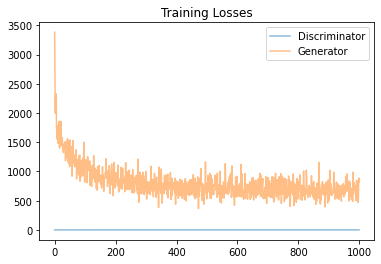

In [6]:
from __future__ import division
import os
import argparse
import sys
sys.argv=['']
del sys

def main(args):

    # Create directory if it doesn't exist.
    if not os.path.exists(args.text2pal_dir):
        os.makedirs(args.text2pal_dir)
    if not os.path.exists(args.pal2color_dir):
        os.makedirs(args.pal2color_dir)
    if not os.path.exists(args.train_sample_dir):
        os.makedirs(args.train_sample_dir)
    if not os.path.exists(os.path.join(args.test_sample_dir, args.mode)):
        os.makedirs(os.path.join(args.test_sample_dir, args.mode))

    # Solver for training and testing Text2Colors.
    solver = Solver(args)

    # Train or test.
    if args.mode == 'train_TPN':
        solver.train_TPN()

    elif args.mode == 'test_TPN':
        solver.test_TPN()

    elif args.mode == 'test_text2colors':
        solver.test_text2colors()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Model configuration.
    # text2pal
    parser.add_argument('--hidden_size', type=int, default=150)
    parser.add_argument('--n_layers', type=int, default=1)
    # pal2color
    parser.add_argument('--always_give_global_hint', type=int, default=1)
    parser.add_argument('--add_L', type=int, default=1)

    # Training and testing configuration.
    parser.add_argument('--mode', type=str, default='train_TPN',
                        choices=['train_TPN', 'train_PCN', 'test_TPN', 'test_text2colors'])
    parser.add_argument('--dataset', type=str, default='bird256', choices=['imagenet', 'bird256'])
    parser.add_argument('--lr', type=float, default=5e-4, help='initial learning rate')
    parser.add_argument('--num_epochs', type=int, default=1000, help='number of epochs for training')
    parser.add_argument('--resume_epoch', type=int, default=None, help='resume training from this epoch')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size for training')
    parser.add_argument('--dropout_p', type=float, default=0.2)
    parser.add_argument('--weight_decay', type=float, default=5e-5)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.99)
    parser.add_argument('--lambda_sL1', type=float, default=100.0, help='weight for L1 loss')
    parser.add_argument('--lambda_KL', type=float, default=0.5, help='weight for KL loss')
    parser.add_argument('--lambda_GAN', type=float, default=0.1)

    # Directories.
    parser.add_argument('--text2pal_dir', type=str, default='./models/TPN')
    parser.add_argument('--pal2color_dir', type=str, default='./models/PCN')
    parser.add_argument('--train_sample_dir', type=str, default='./samples/train')
    parser.add_argument('--test_sample_dir', type=str, default='./samples/test')

    # Step size.
    parser.add_argument('--log_interval', type=int, default=1,
                        help='how many steps to wait before logging training status')
    parser.add_argument('--sample_interval', type=int, default=20,
                        help='how many steps to wait before saving the training output')
    parser.add_argument('--save_interval', type=int, default=50,
                        help='how many steps to wait before saving the trained models')
    
    
    args = parser.parse_args()
    print(args)
    main(args)

Namespace(add_L=1, always_give_global_hint=1, batch_size=32, beta1=0.5, beta2=0.99, dataset='bird256', dropout_p=0.2, hidden_size=150, lambda_GAN=0.1, lambda_KL=0.5, lambda_sL1=100.0, log_interval=1, lr=0.0005, mode='test_TPN', n_layers=1, num_epochs=1000, pal2color_dir='./models/PCN', resume_epoch=500, sample_interval=20, save_interval=50, test_sample_dir='./samples/test', text2pal_dir='./models/TPN', train_sample_dir='./samples/train', weight_decay=5e-05)
Loading 10183 palette names...
Making text dictionary...
Using pre-trained word embeddings...
Loading the trained model from epoch 500...
Start testing...
Saved data [1], input text [communism ], test sample [1]
Saved data [2], input text [dark neon ], test sample [1]
Saved data [3], input text [dont talk to me ], test sample [1]
Saved data [4], input text [good night princess ], test sample [1]
Saved data [5], input text [good morning princess ], test sample [1]
Saved data [6], input text [dusty blue ], test sample [1]
Saved data [

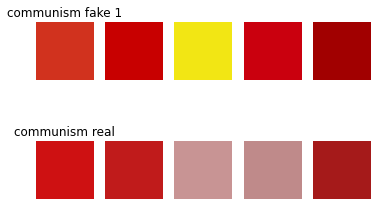

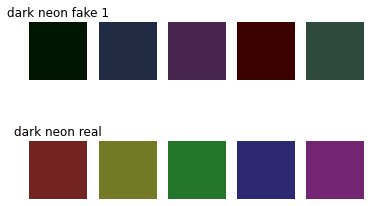

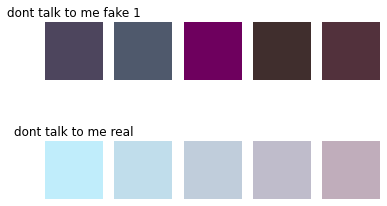

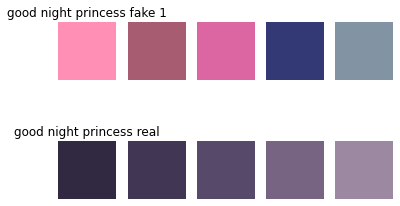

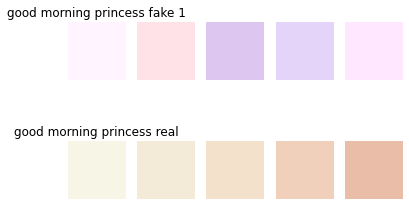

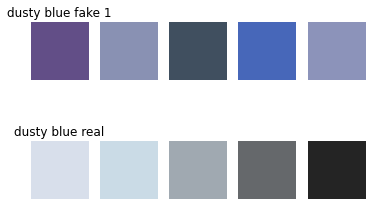

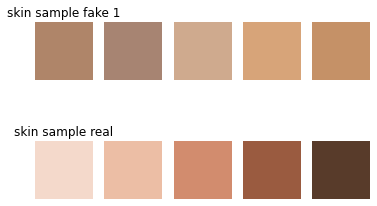

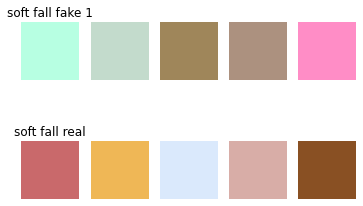

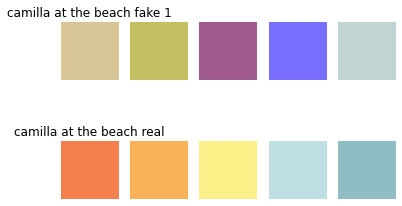

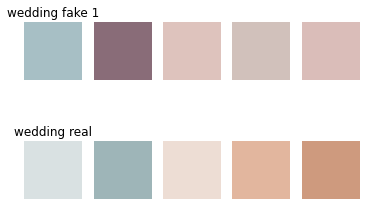

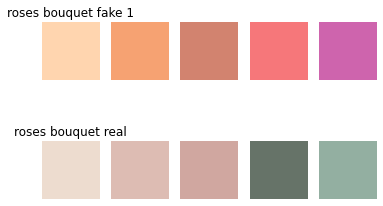

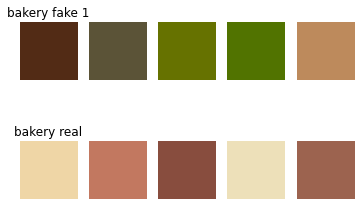

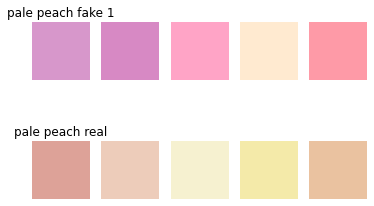

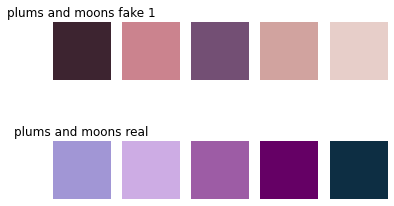

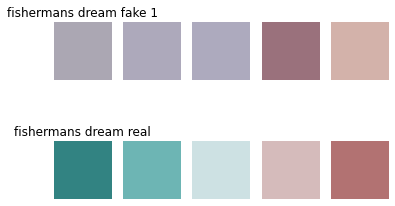

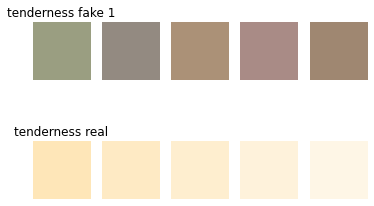

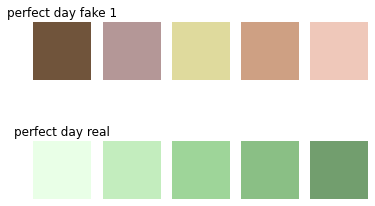

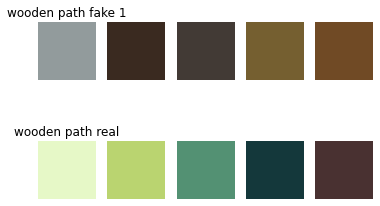

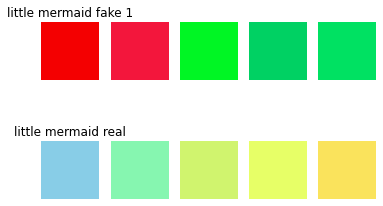

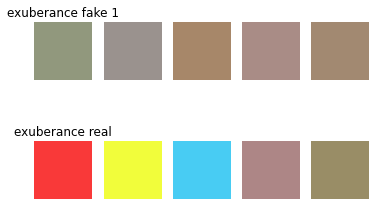

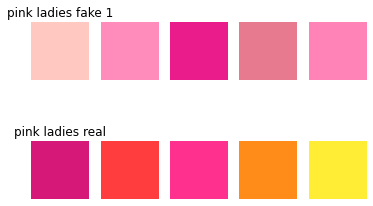

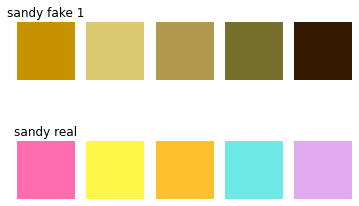

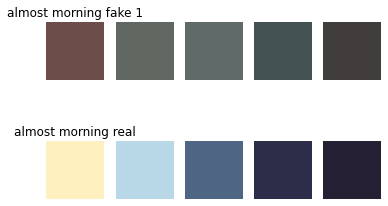

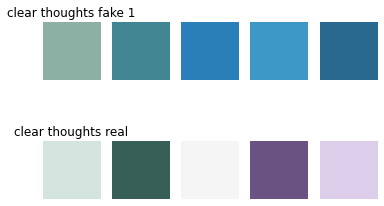

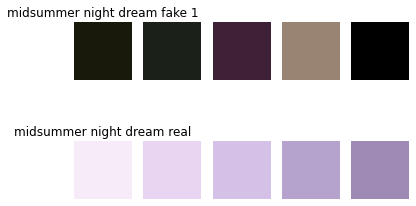

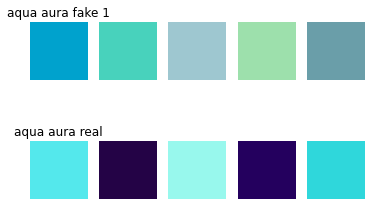

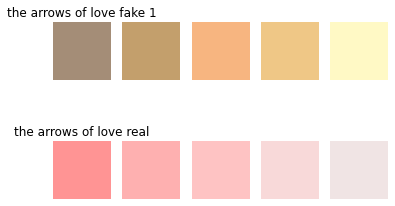

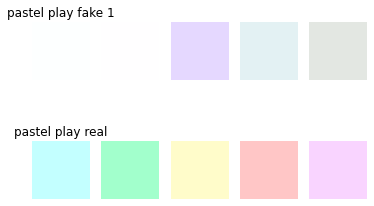

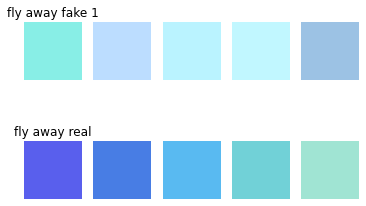

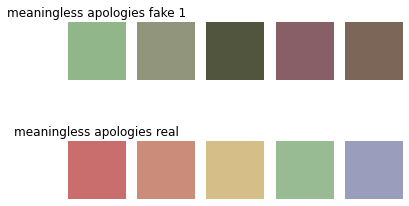

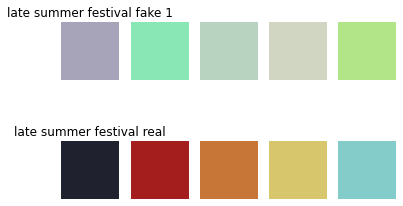

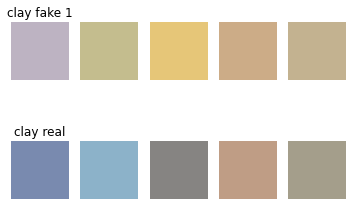

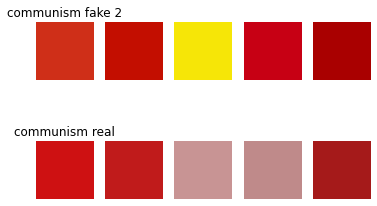

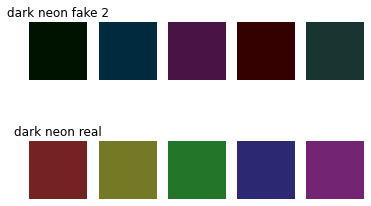

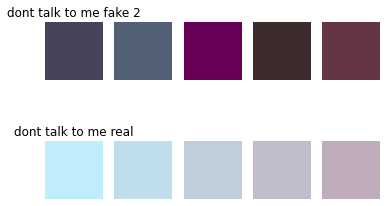

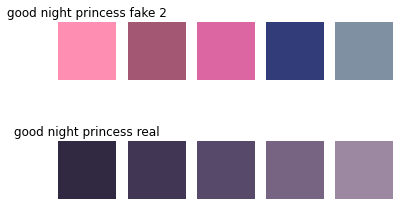

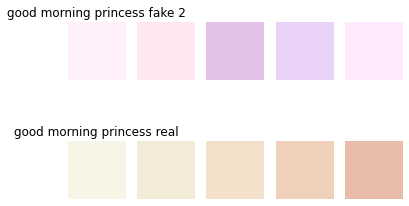

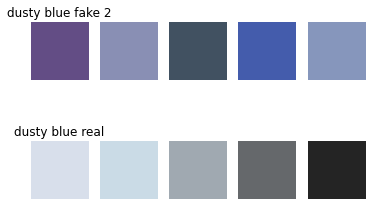

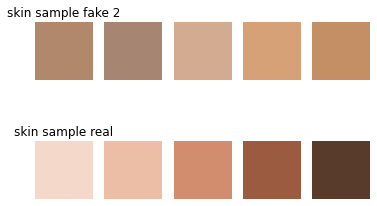

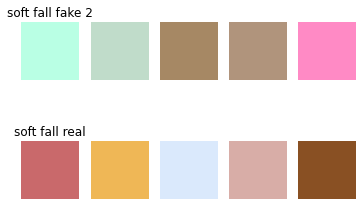

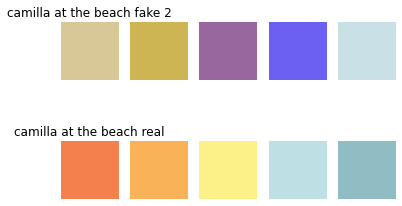

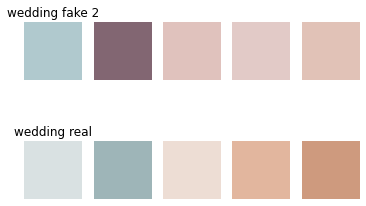

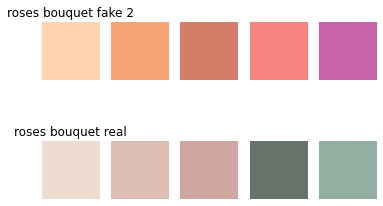

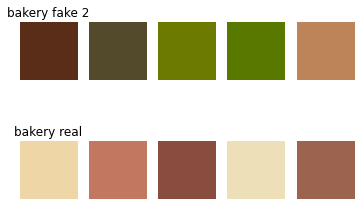

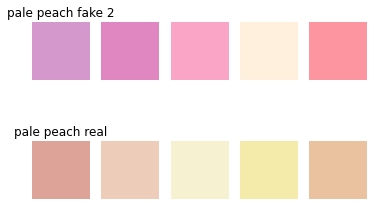

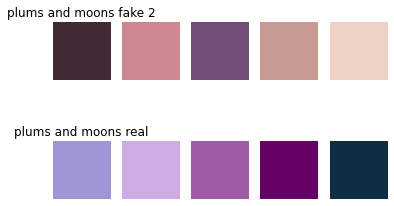

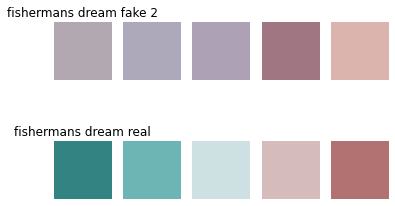

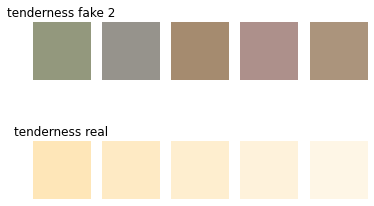

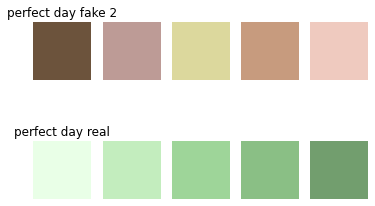

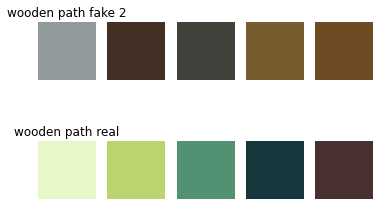

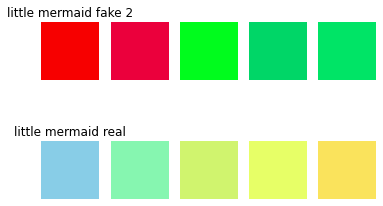

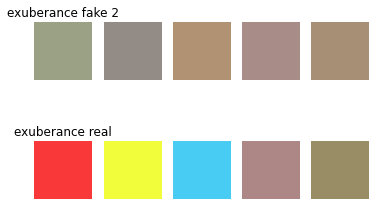

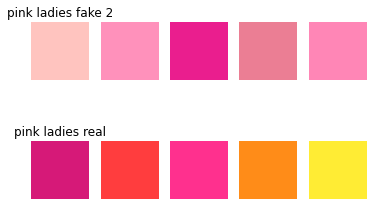

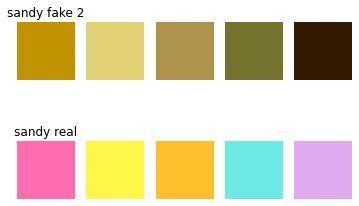

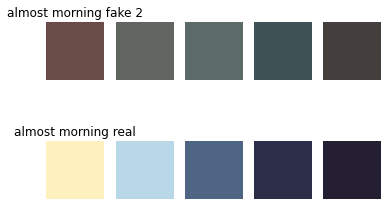

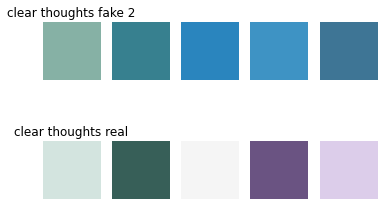

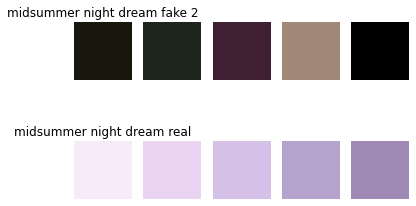

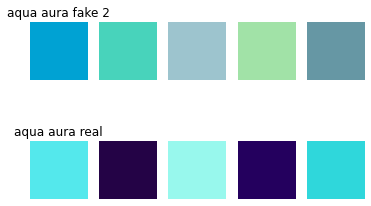

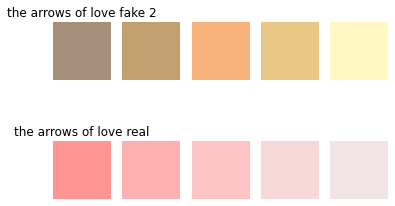

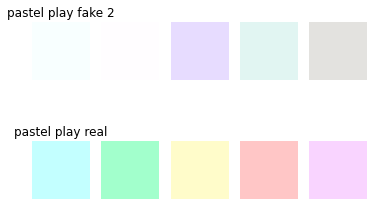

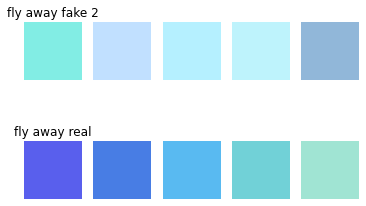

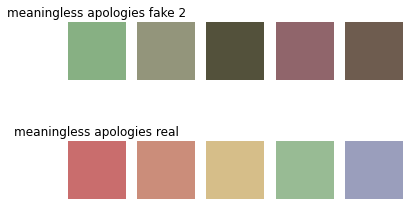

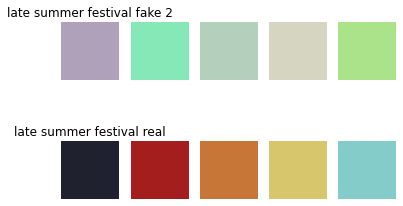

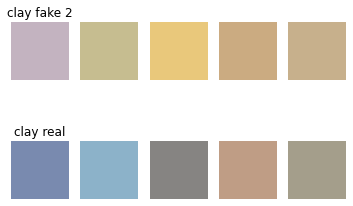

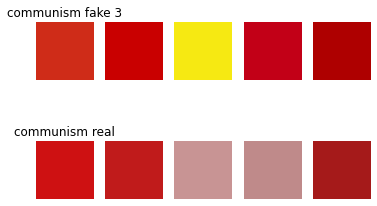

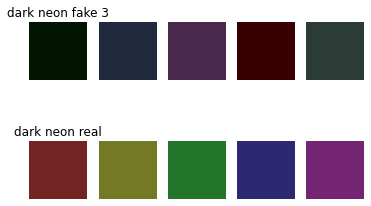

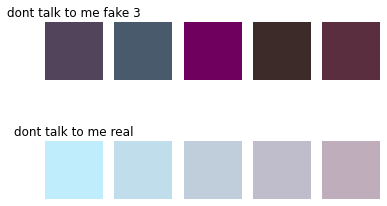

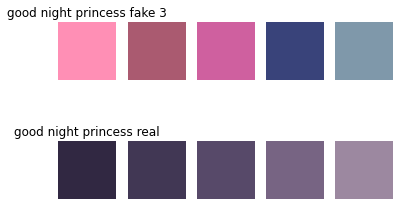

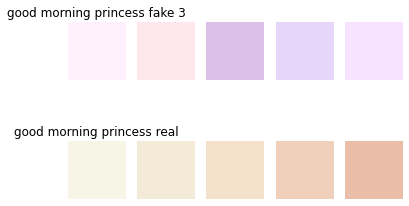

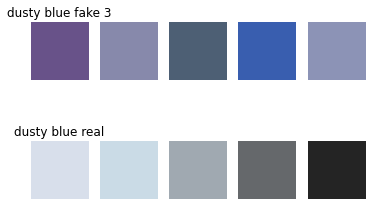

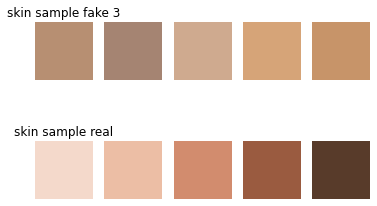

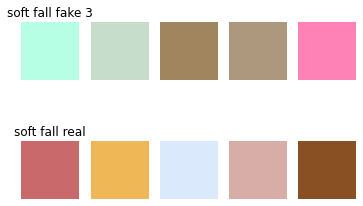

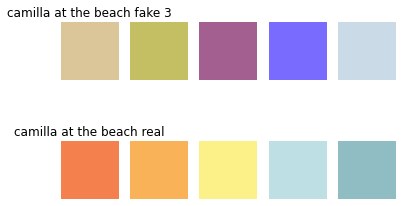

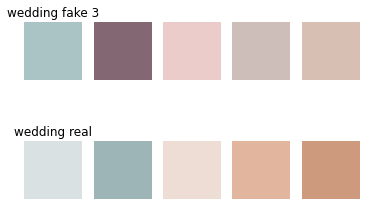

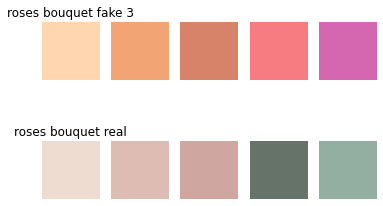

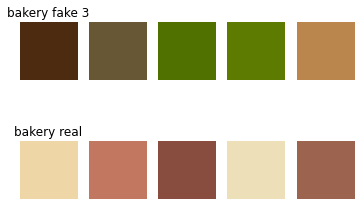

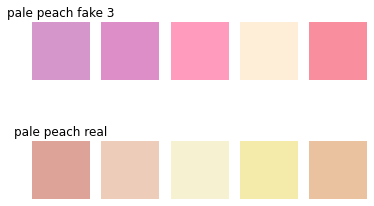

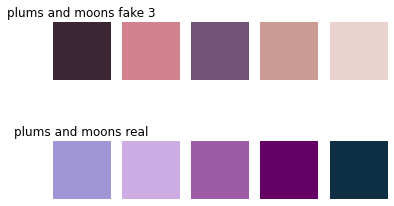

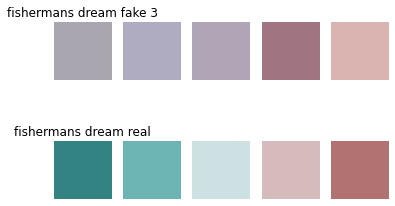

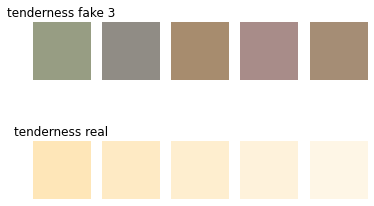

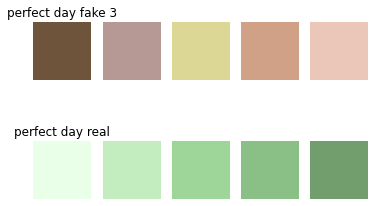

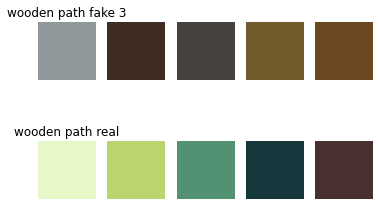

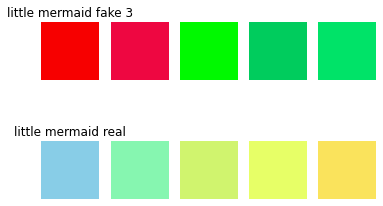

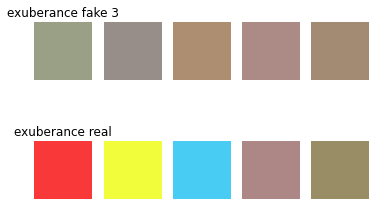

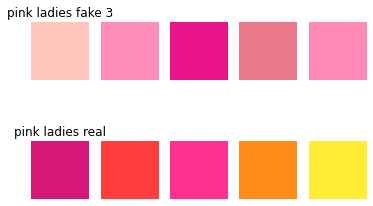

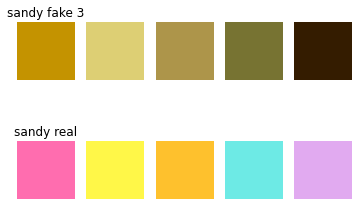

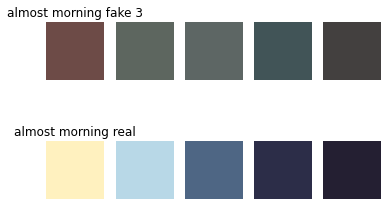

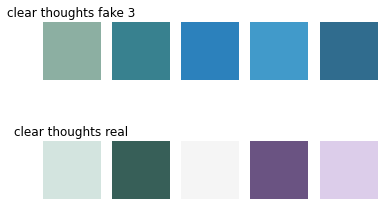

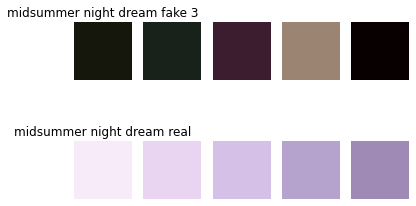

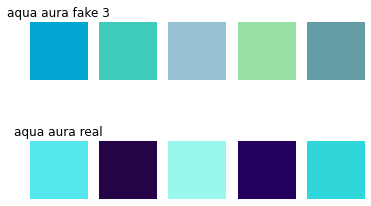

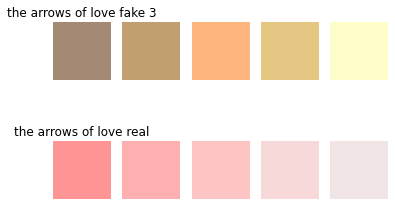

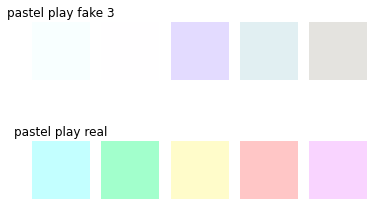

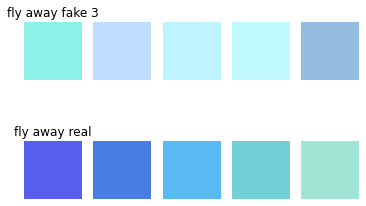

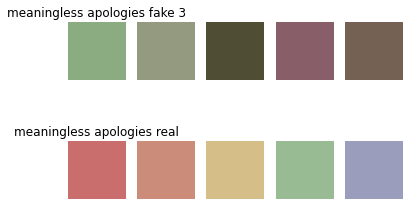

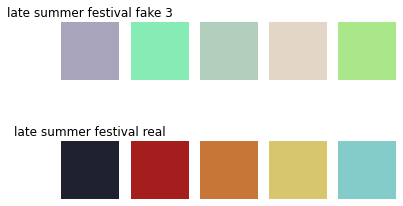

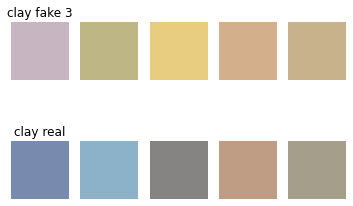

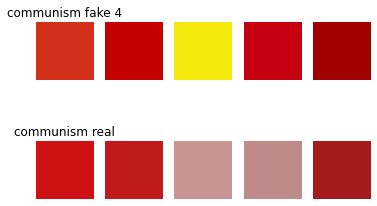

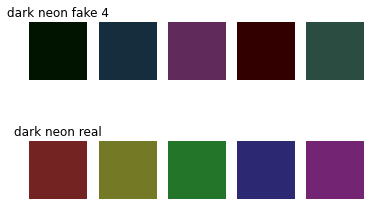

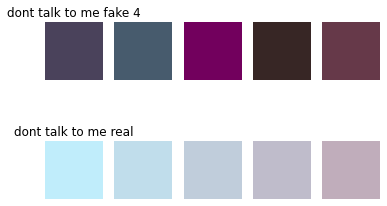

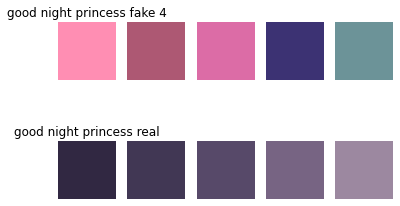

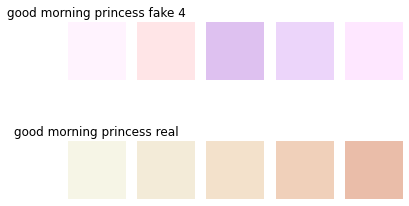

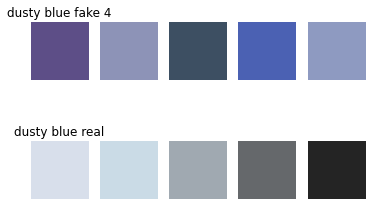

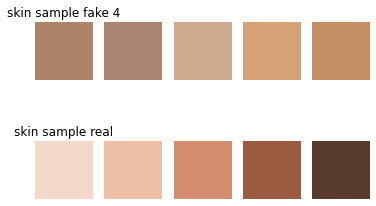

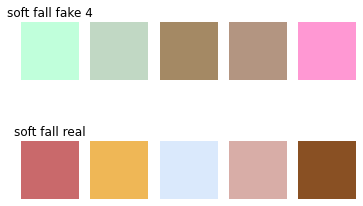

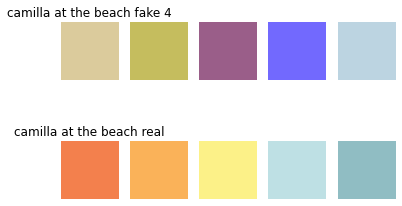

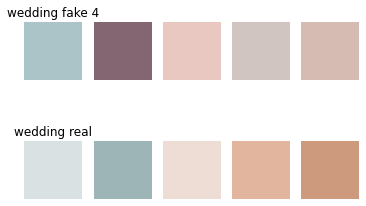

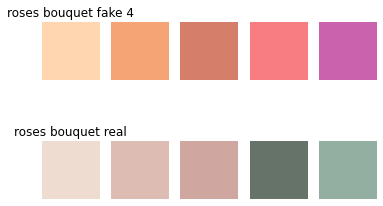

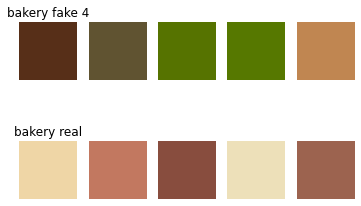

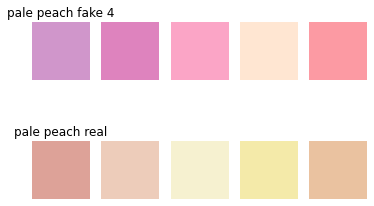

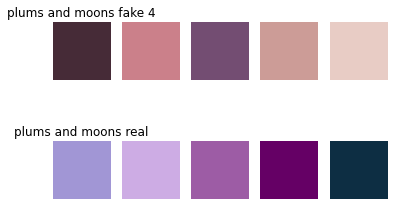

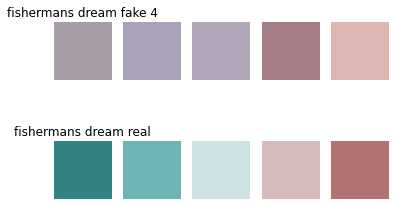

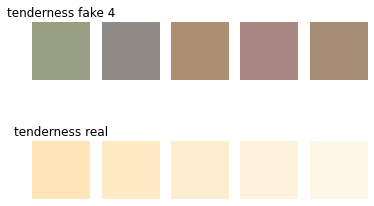

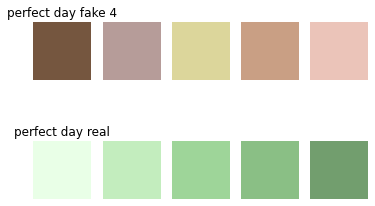

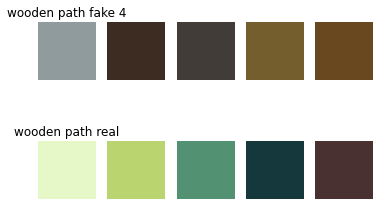

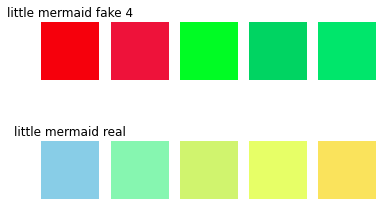

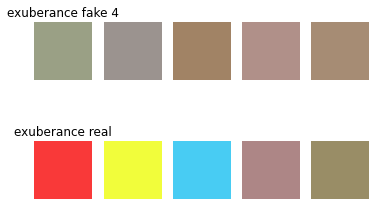

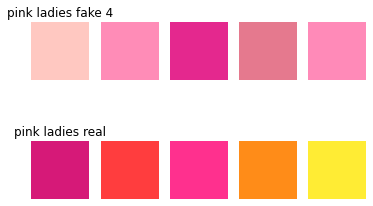

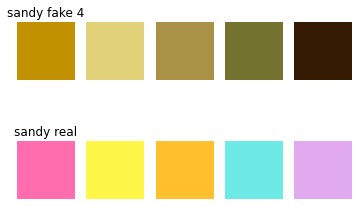

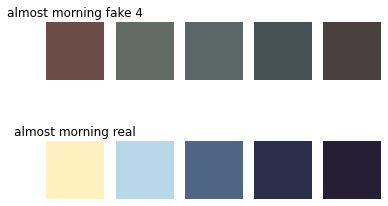

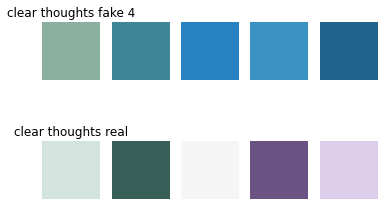

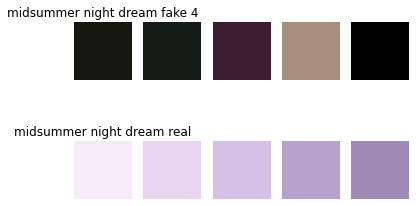

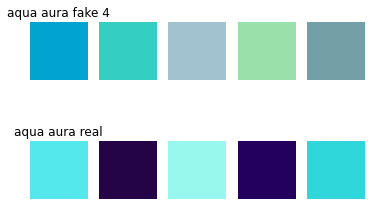

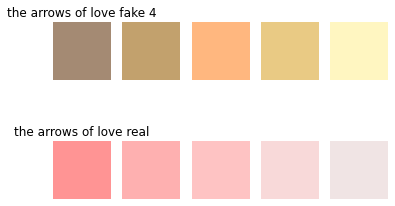

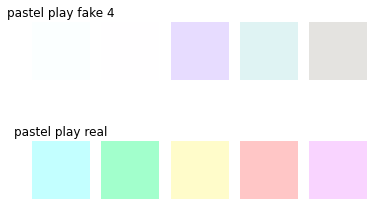

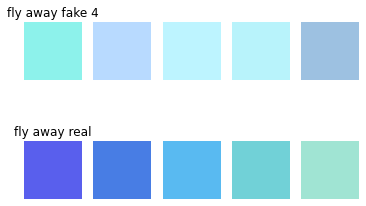

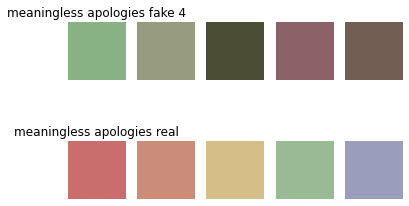

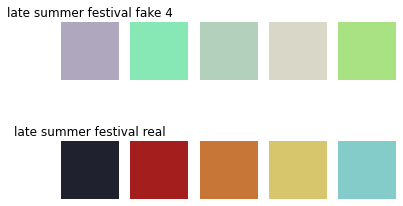

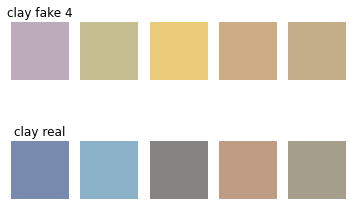

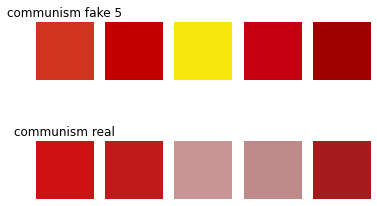

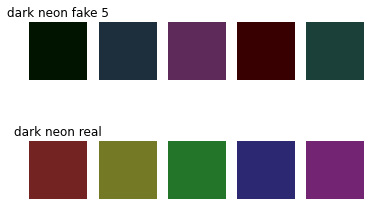

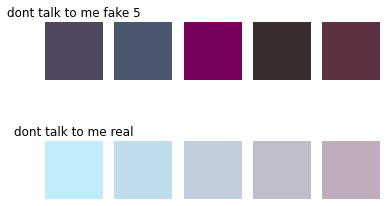

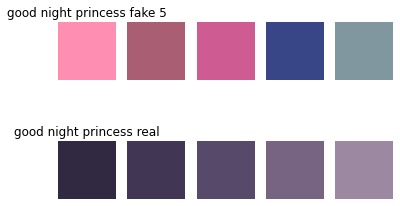

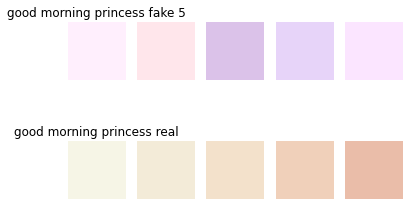

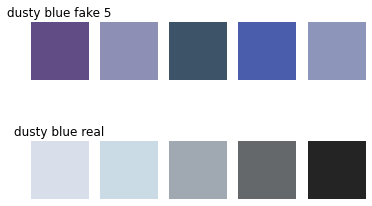

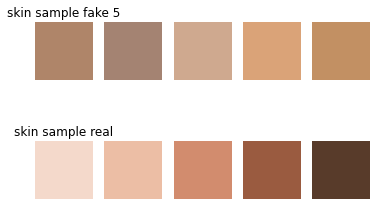

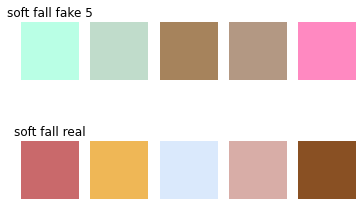

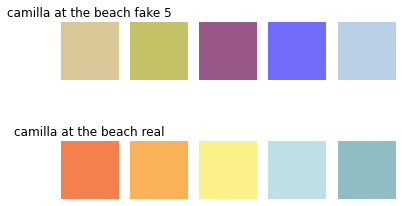

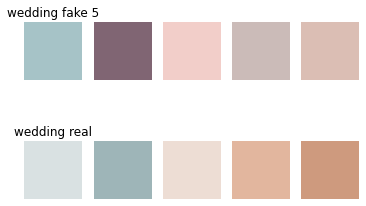

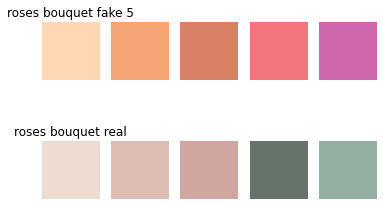

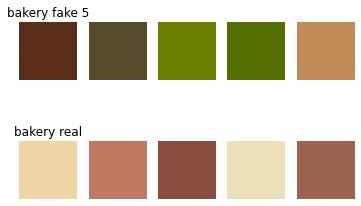

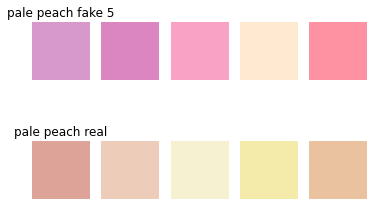

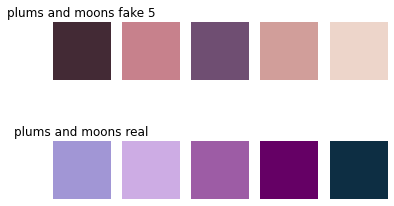

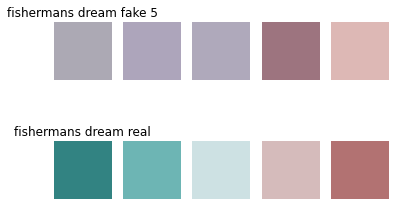

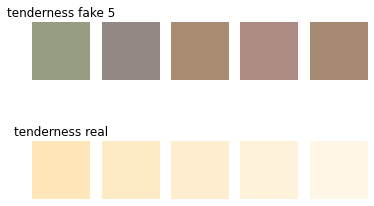

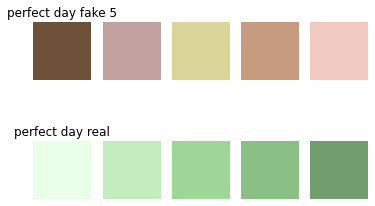

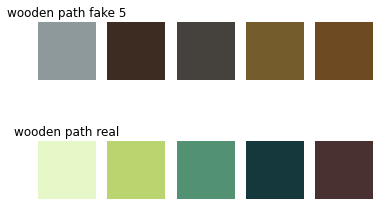

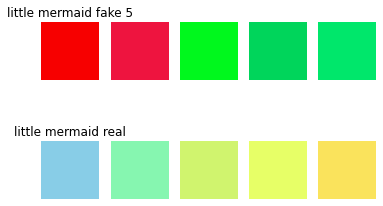

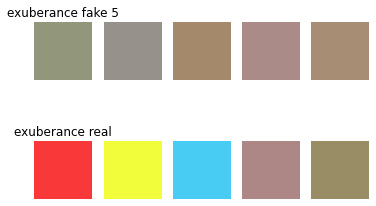

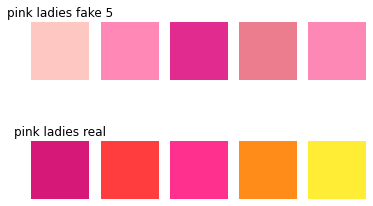

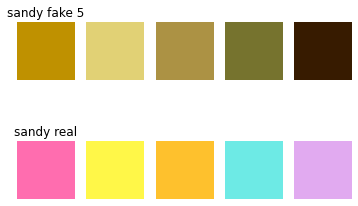

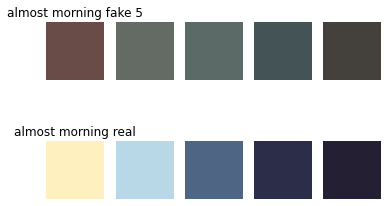

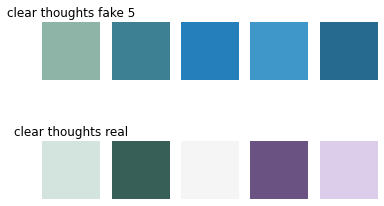

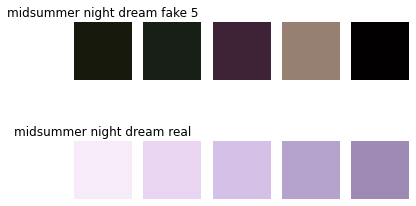

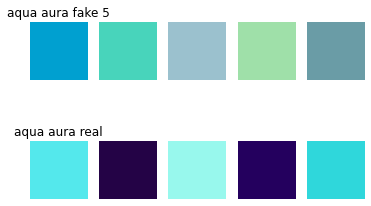

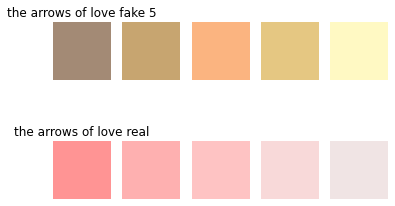

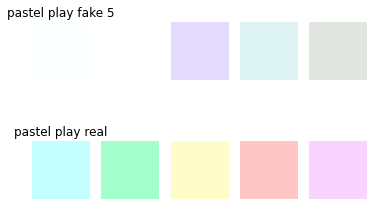

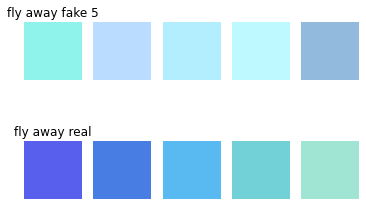

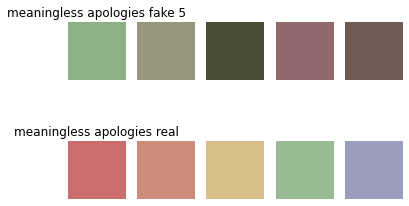

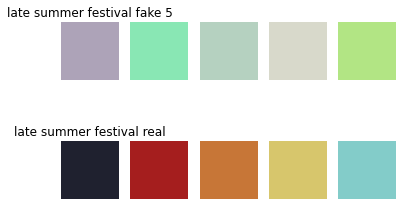

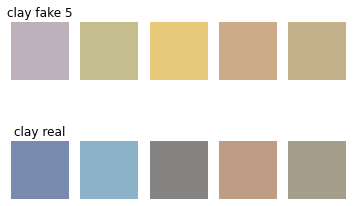

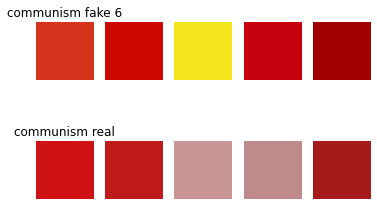

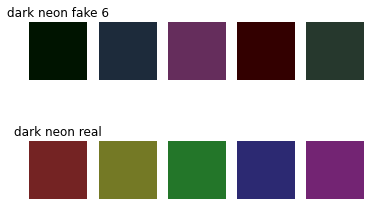

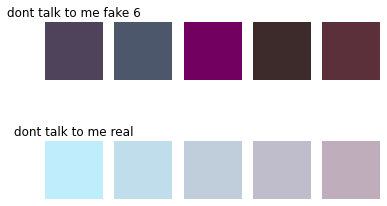

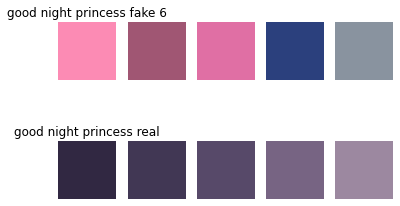

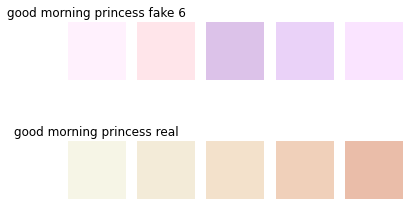

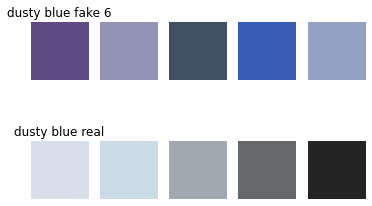

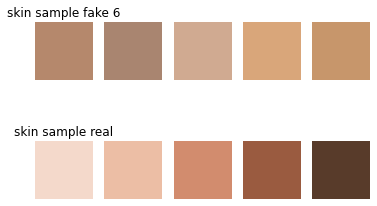

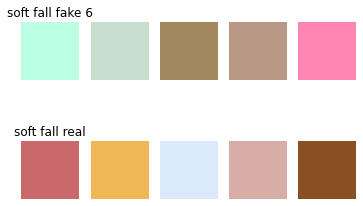

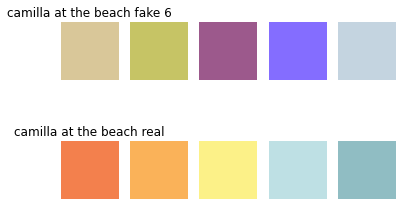

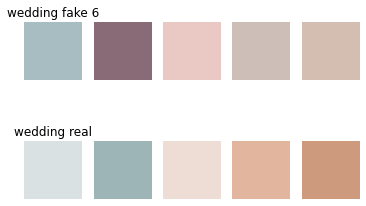

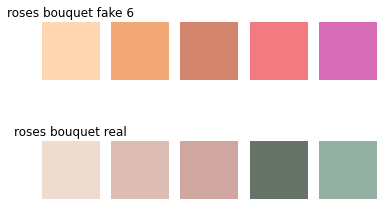

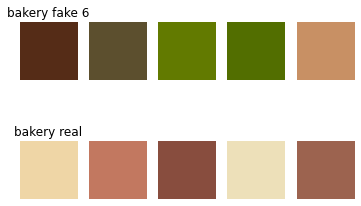

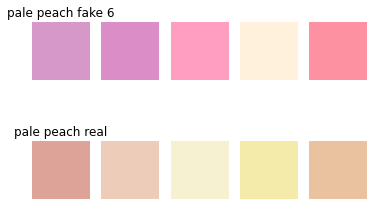

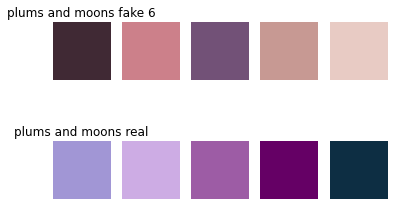

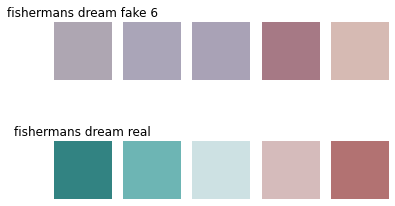

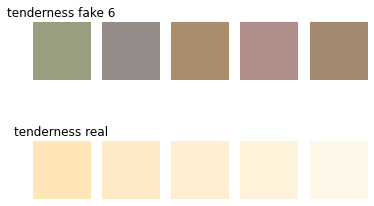

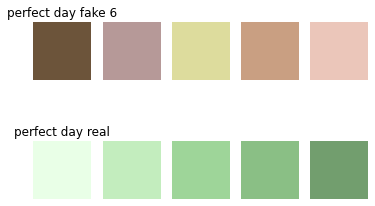

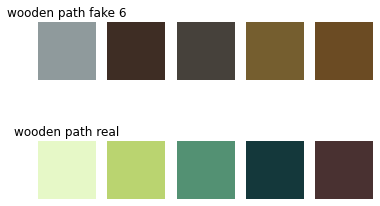

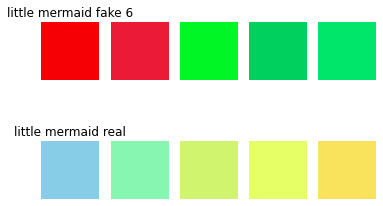

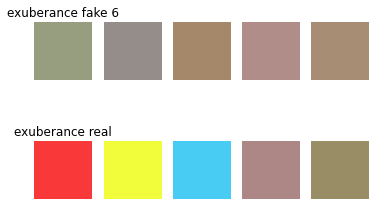

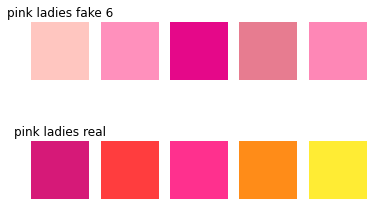

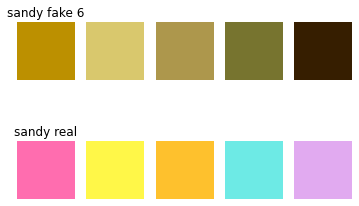

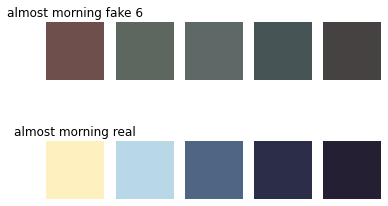

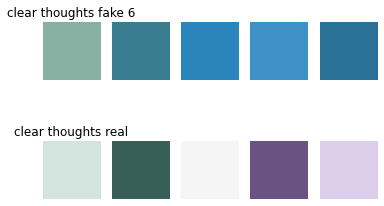

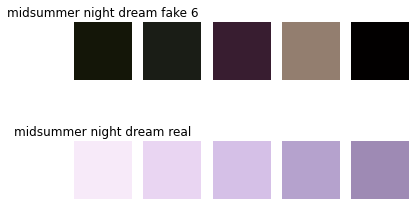

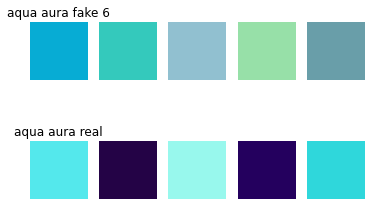

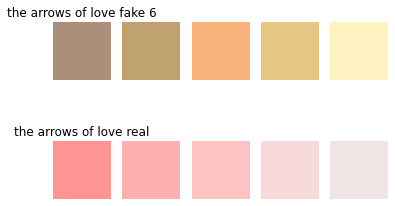

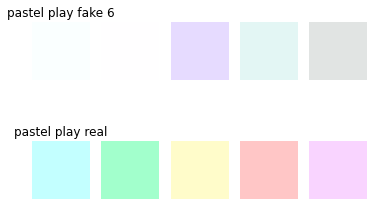

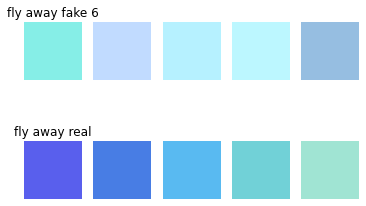

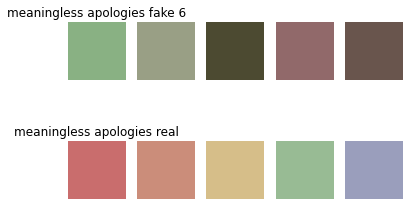

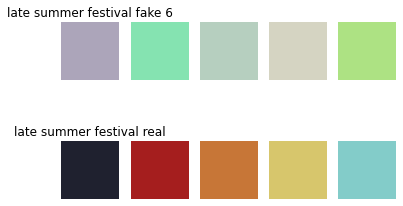

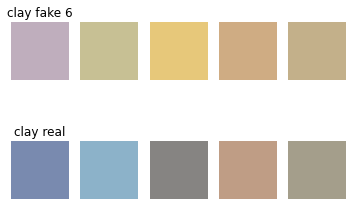

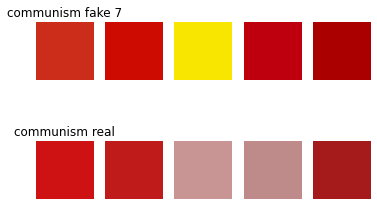

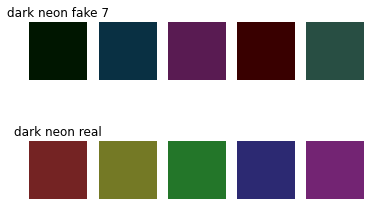

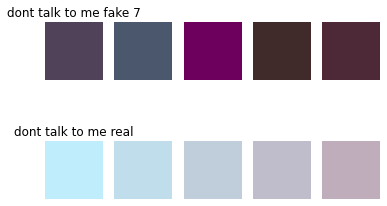

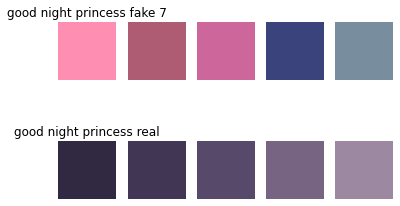

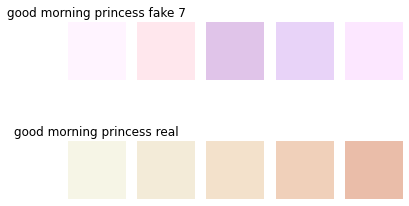

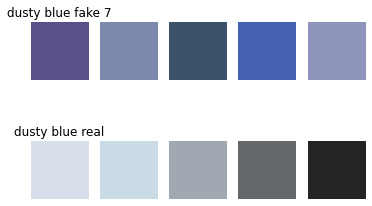

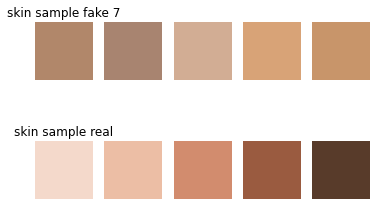

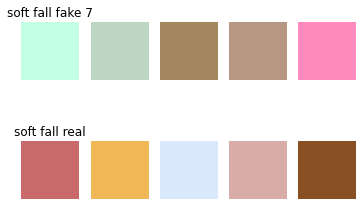

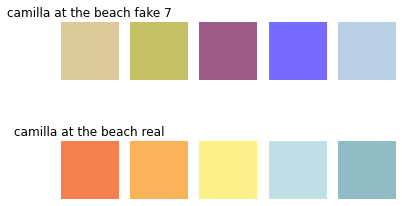

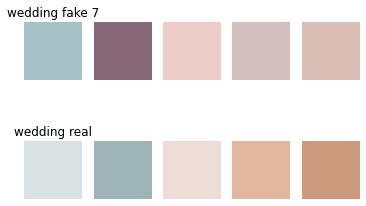

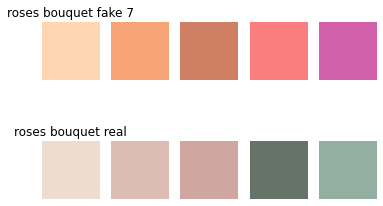

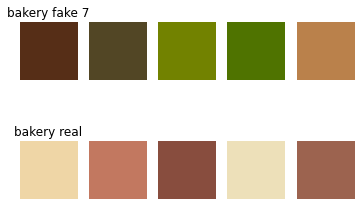

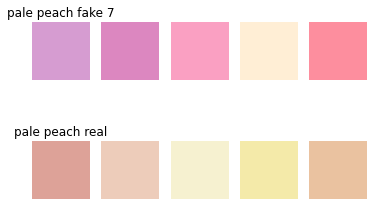

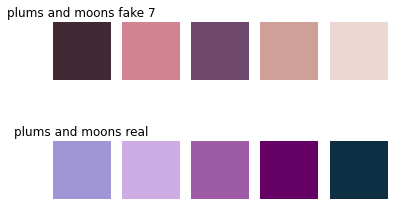

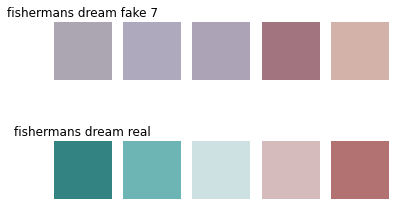

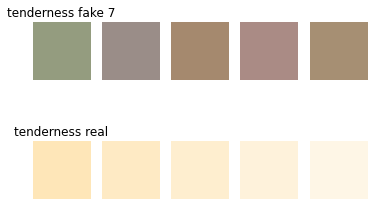

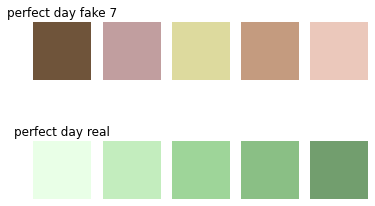

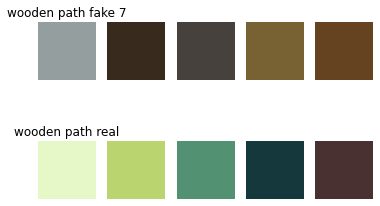

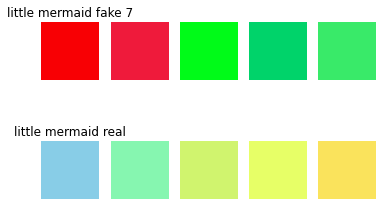

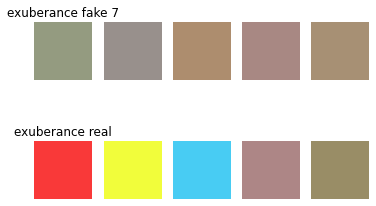

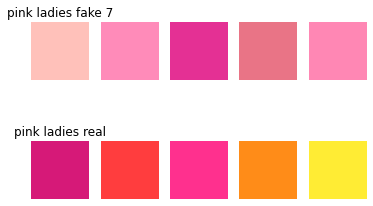

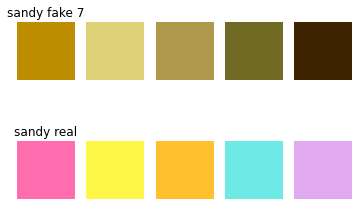

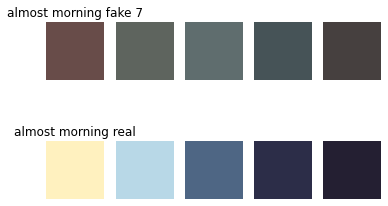

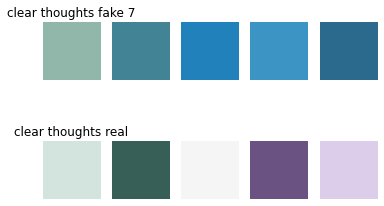

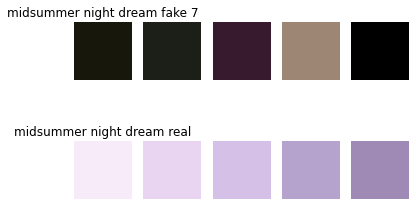

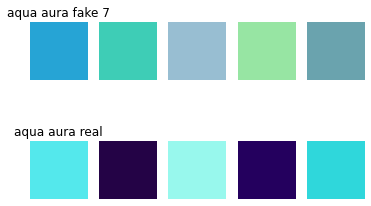

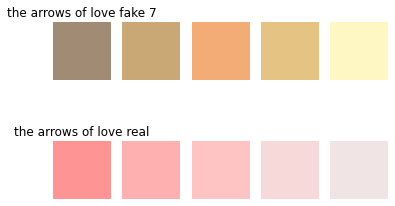

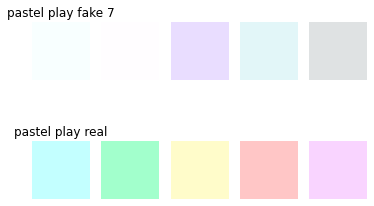

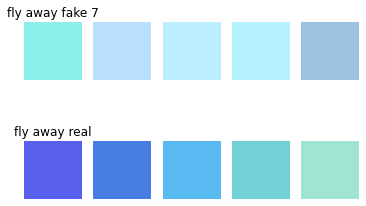

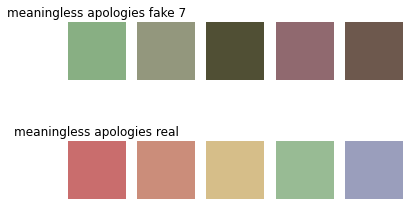

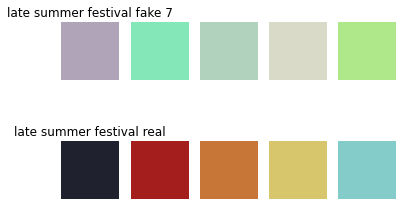

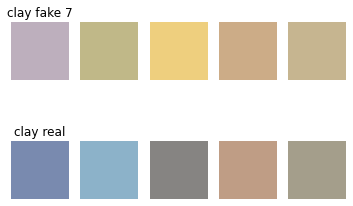

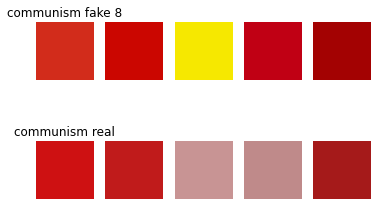

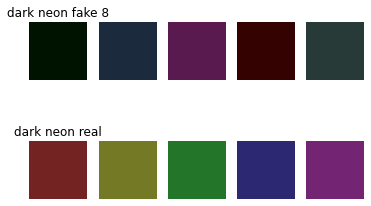

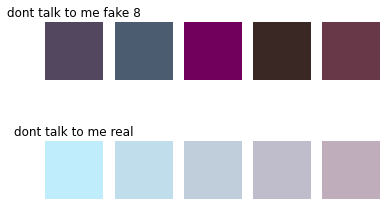

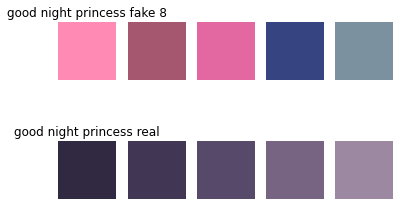

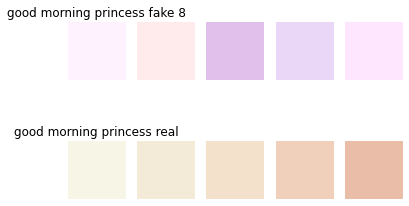

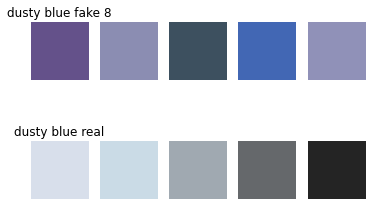

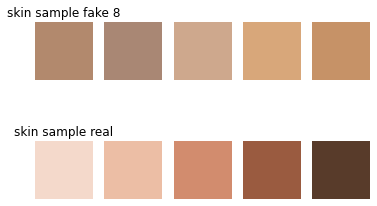

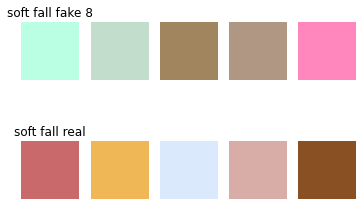

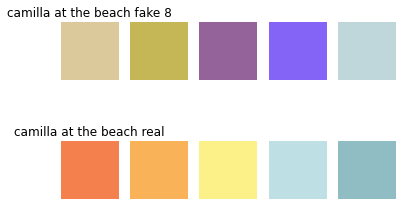

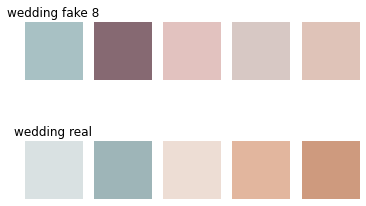

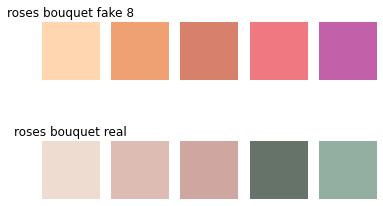

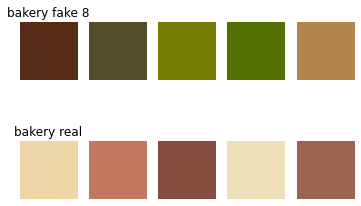

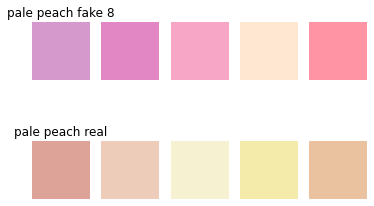

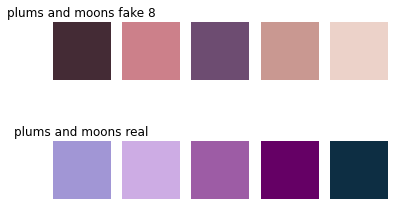

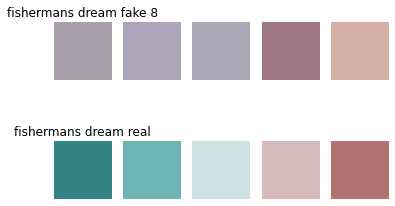

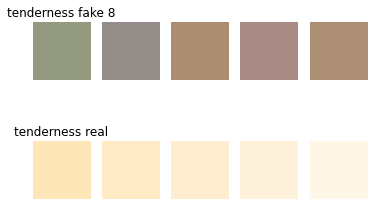

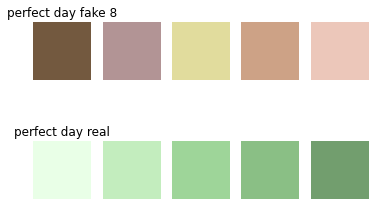

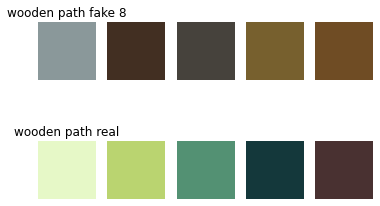

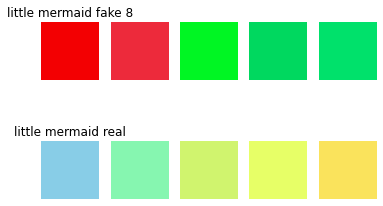

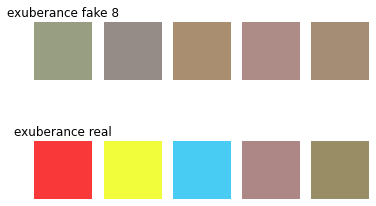

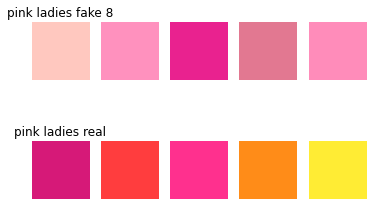

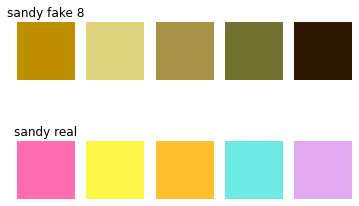

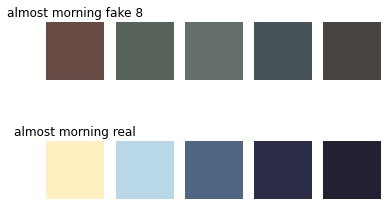

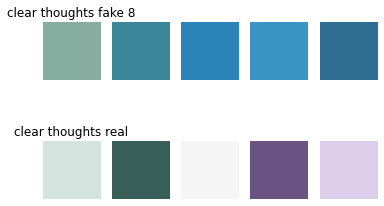

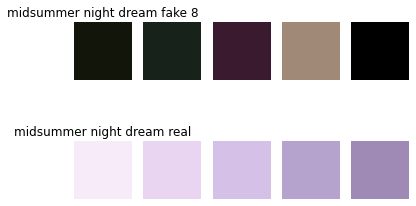

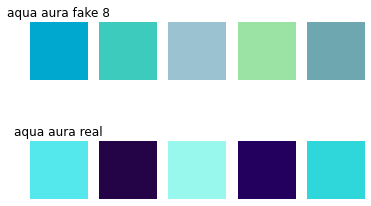

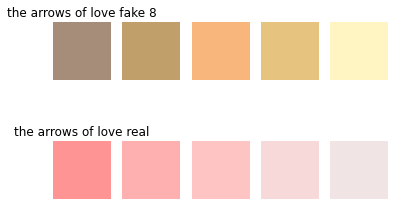

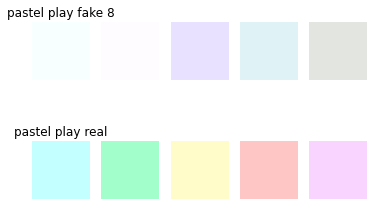

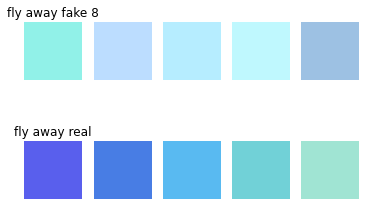

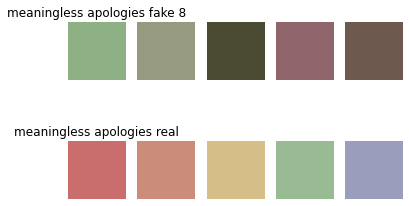

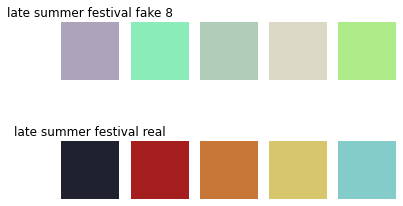

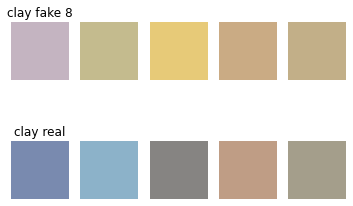

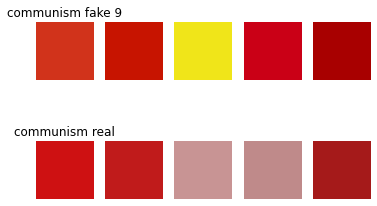

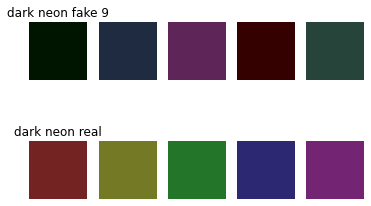

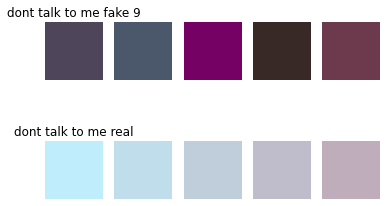

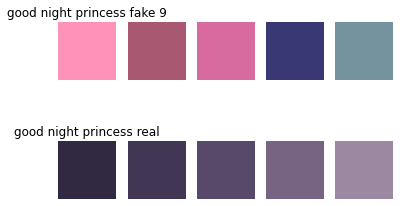

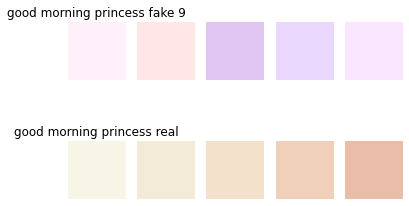

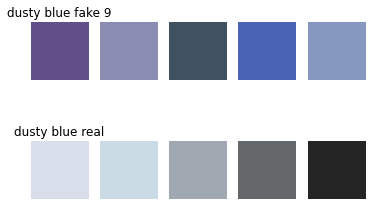

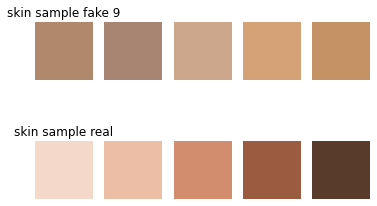

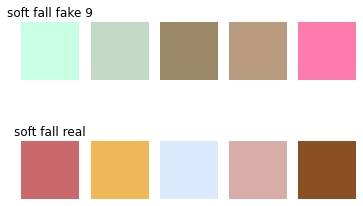

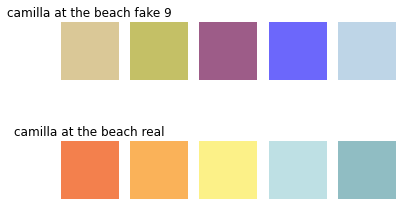

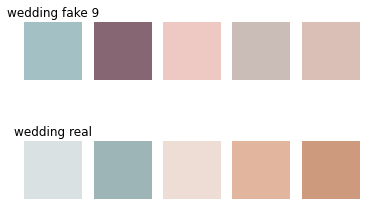

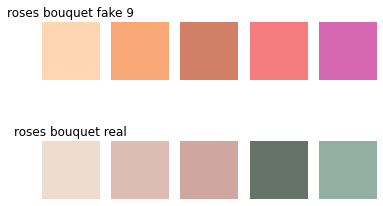

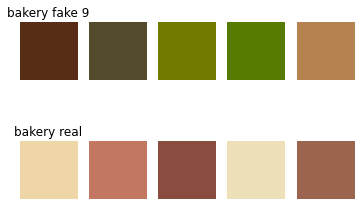

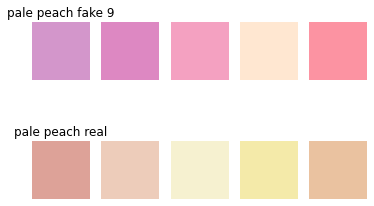

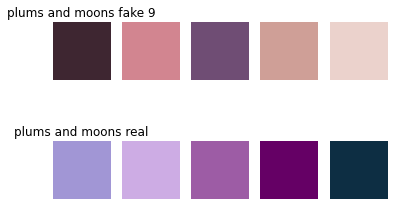

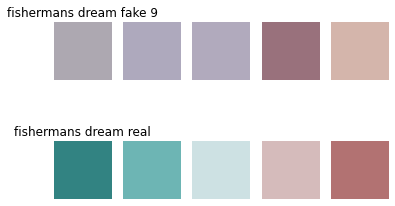

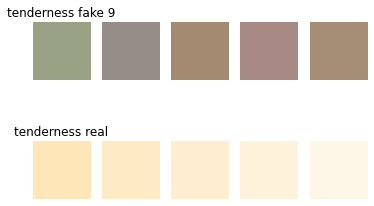

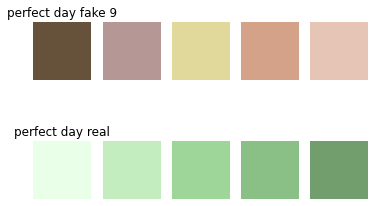

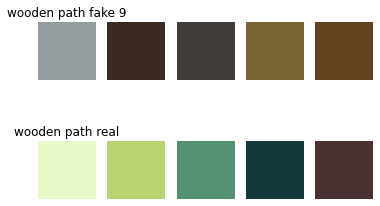

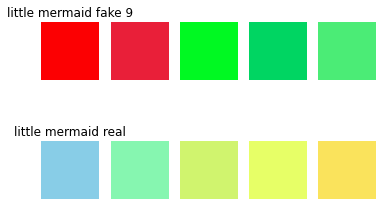

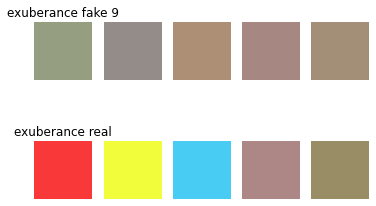

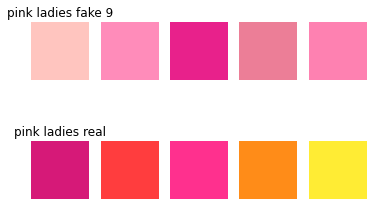

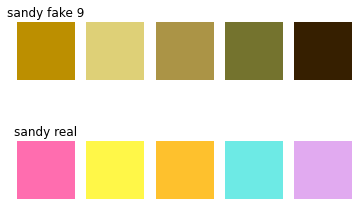

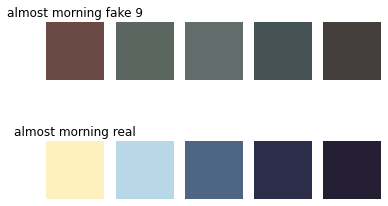

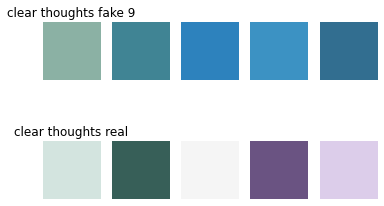

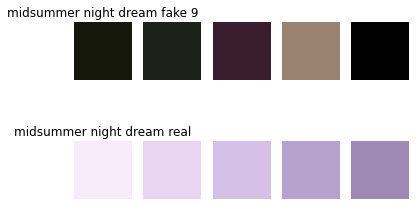

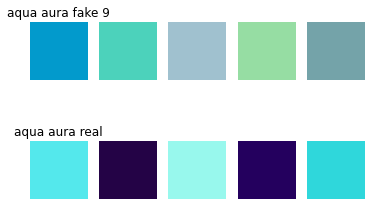

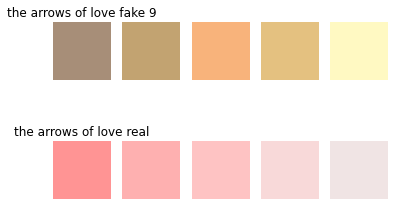

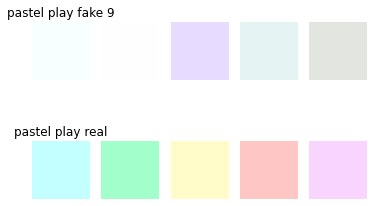

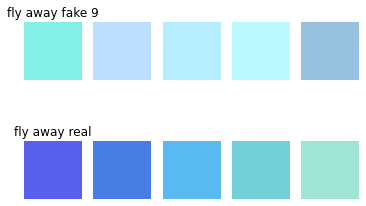

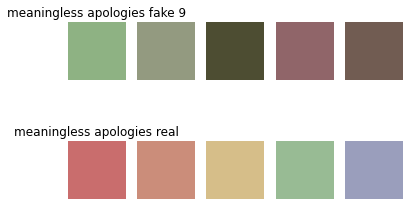

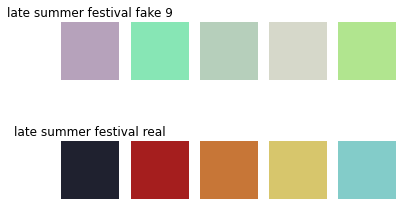

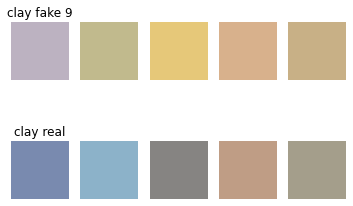

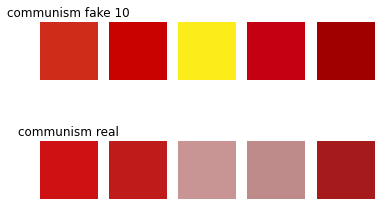

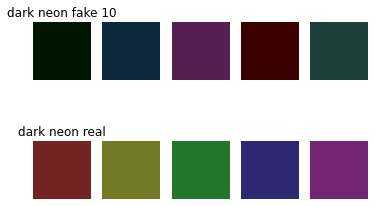

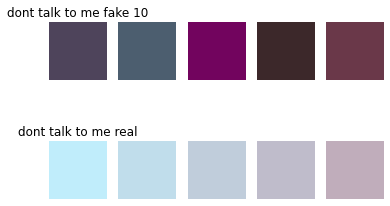

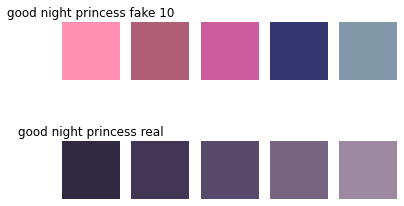

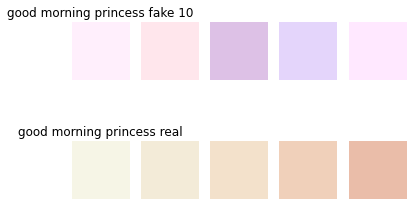

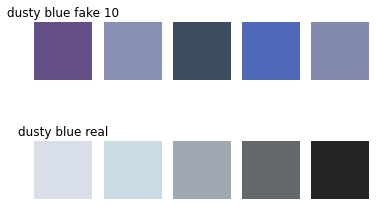

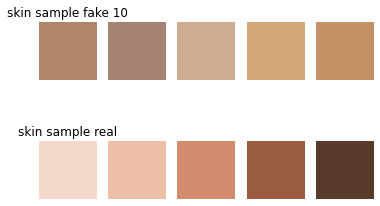

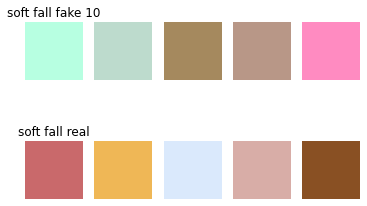

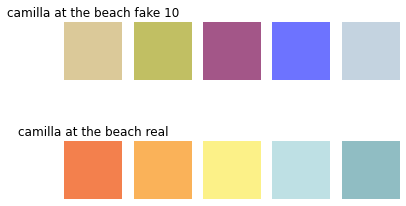

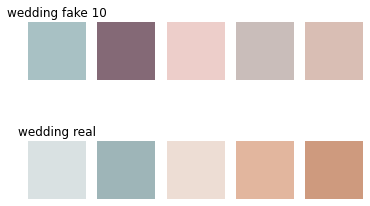

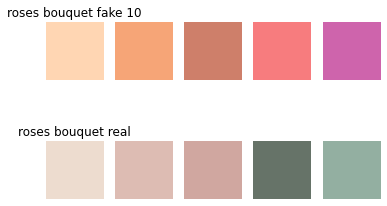

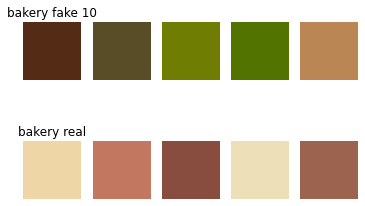

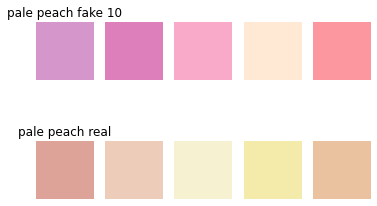

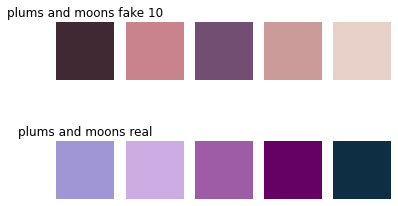

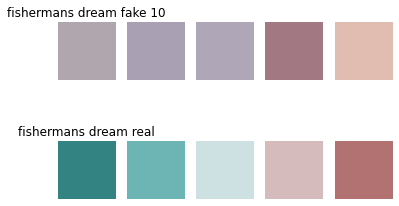

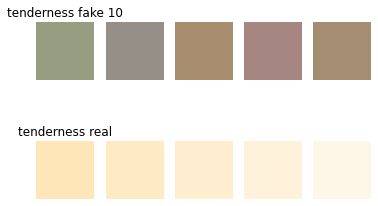

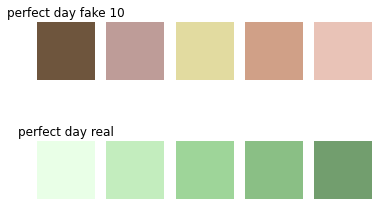

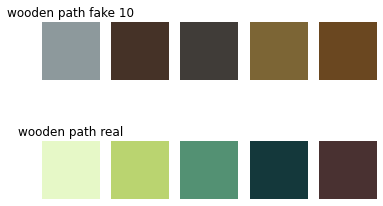

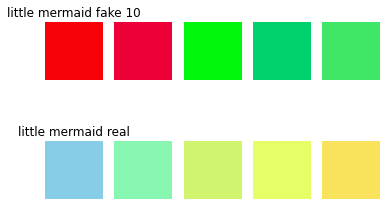

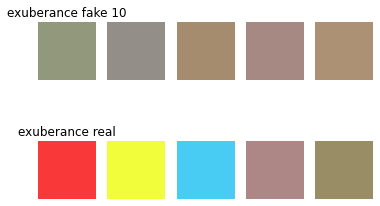

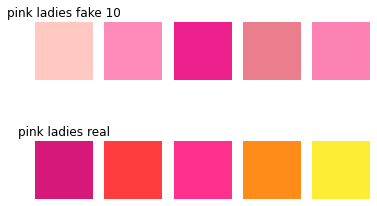

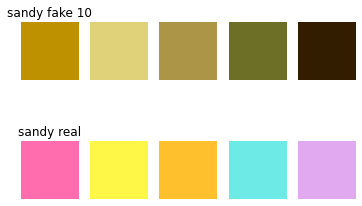

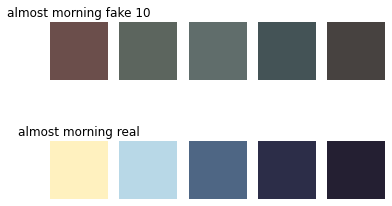

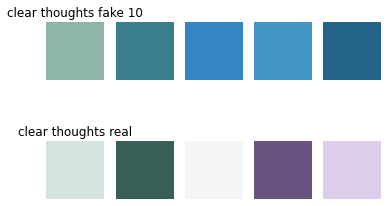

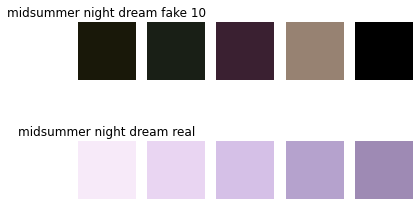

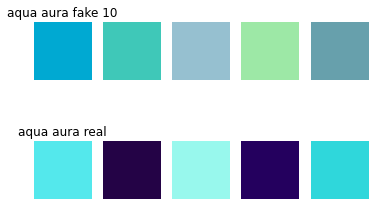

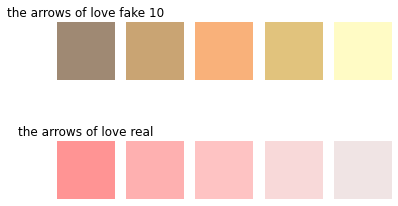

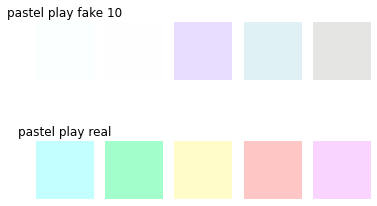

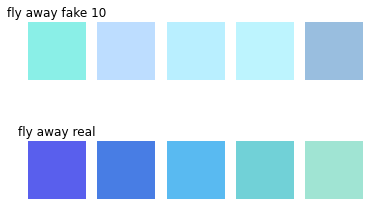

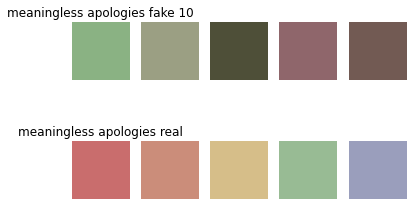

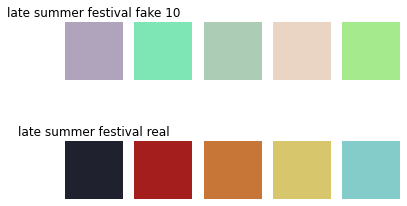

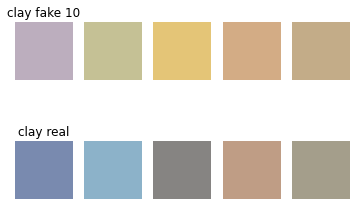

In [7]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Model configuration.
    # text2pal
    parser.add_argument('--hidden_size', type=int, default=150)
    parser.add_argument('--n_layers', type=int, default=1)
    # pal2color
    parser.add_argument('--always_give_global_hint', type=int, default=1)
    parser.add_argument('--add_L', type=int, default=1)

    # Training and testing configuration.
    parser.add_argument('--mode', type=str, default='test_TPN',
                        choices=['train_TPN', 'train_PCN', 'test_TPN', 'test_text2colors'])
    parser.add_argument('--dataset', type=str, default='bird256', choices=['imagenet', 'bird256'])
    parser.add_argument('--lr', type=float, default=5e-4, help='initial learning rate')
    parser.add_argument('--num_epochs', type=int, default=1000, help='number of epochs for training')
    parser.add_argument('--resume_epoch', type=int, default=500, help='resume training from this epoch')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size for training')
    parser.add_argument('--dropout_p', type=float, default=0.2)
    parser.add_argument('--weight_decay', type=float, default=5e-5)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.99)
    parser.add_argument('--lambda_sL1', type=float, default=100.0, help='weight for L1 loss')
    parser.add_argument('--lambda_KL', type=float, default=0.5, help='weight for KL loss')
    parser.add_argument('--lambda_GAN', type=float, default=0.1)

    # Directories.
    parser.add_argument('--text2pal_dir', type=str, default='./models/TPN')
    parser.add_argument('--pal2color_dir', type=str, default='./models/PCN')
    parser.add_argument('--train_sample_dir', type=str, default='./samples/train')
    parser.add_argument('--test_sample_dir', type=str, default='./samples/test')

    # Step size.
    parser.add_argument('--log_interval', type=int, default=1,
                        help='how many steps to wait before logging training status')
    parser.add_argument('--sample_interval', type=int, default=20,
                        help='how many steps to wait before saving the training output')
    parser.add_argument('--save_interval', type=int, default=50,
                        help='how many steps to wait before saving the trained models')
    
    args = parser.parse_args()
    print(args)
    main(args)